# Assignment Module 8

### Group Members:
- Julian Ruggiero
- Omar M. Hussein
- Eli weiss

## Introduction

A bank loan is a personal loan that's issued by either a local or national bank. There are many factor that lead to an individual’sloan being accepted or not. In this assignment we are going to create a series of binary logistic regression models that predict whether or not a given mortgage application is likely to be denied which will help us further understand to what degree each feature affects the likelihood of the loan being accepted by the bank. After constructing and evaluating the logistic regression models, we will identify our preferred model and apply it to a testing subset to assess its performance.

## Data Profiling

The data set is sourced from the Federal Reserve Bank of Boston. A brief overview of the content of the data set can be found here: <br>
https://vincentarelbundock.github.io/Rdatasets/doc/Ecdat/Hdma.html

The data set is comprised of 2,381 observations of 1 response/dependent variable (which indicates whether or not a mortgage application was denied) and 12 explanatory/independent variables.

- __dir:__ debt payments to total income ratio. According to Investopedia the highest that company will usually lend 43% while private investors have been known to lend on up to 55% DTI. However, there is no limit on a DTI. [Link](https://dreamhomefinancing.com/high-dti-mortgage-lenders/) 
- __hir:__ housing expenses to income ratio. According to Bankrate.com the highest a house expense to income ratio can go is 28% with exceptions for people with good credit and other factors. [Link](https://www.bankrate.com/glossary/h/housing-expense-ratio/)
- __lvr:__ ratio of size of loan to assessed value of property. The highest Loan to value ratio is normally 97%, however an application can have ratio on it with no limit. [Link](https://www.investopedia.com/terms/l/loantovalue.asp)
- __ccs:__ consumer credit score from 1 to 6 (a low value being a good score)
- __mcs:__ mortgage credit score from 1 to 4 (a low value being a good score)
- __pbcr:__ public bad credit record ?
- __dmi:__ denied mortgage insurance ?
- __self:__ self employed ?
- __single:__ is the applicant single ?
- __uria:__ 1989 Massachusetts unemployment rate in the applicant's industry
- __condominium:__ is unit a condominium ? (was called comdominiom in version 0.2-9 and earlier versions of the package)
- __black:__ is the applicant black ?
- __deny (response):__ mortgage application denied ?

Below we create a meaningful list of column names and separate the numeric and categorical features.

In [1]:
#create a list of meaningful column names
columns=['debt_pymt_income_ratio', 'house_expen_income_ratio', 'loan_size_prop_value_ratio', 'cons_cred_score',
         'mort_cred_score', 'bad_credit_record','denied_mort_insur','self_emp', 'single', 'unemp_rate_app_industry',
         'unit_condo','black','deny']

# split categorical and numeric features
categorical = ['bad_credit_record', 'denied_mort_insur', 'self_emp', 'single', 'unit_condo', 'black', 
               'cons_cred_score', 'mort_cred_score']

numeric = ['debt_pymt_income_ratio', 'house_expen_income_ratio', 
           'loan_size_prop_value_ratio', 
           'unemp_rate_app_industry']

# Exploratory Data Analysis

### Logistic Regression Assumptions
- Binary logistic regression requires the dependent variable to be binary.
- For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome.
- Only the meaningful variables should be included.
- The independent variables should be independent of each other. That is, the model should have little or no multicollinearity.
- The independent variables are linearly related to the log odds.
- Logistic regression requires quite large sample sizes.

Keeping the above assumptions in mind, let’s look at our dataset.

First we will read the data into python using pandas read csv function. We will replace the column names to the ones we define to be more meaningful for analysis purposes. Then we will look for missing and/or invalid data values and perform an exploratory data analysis on our dataset to determine what data need to be prepared for a future machine learning model.

In [2]:
# importing libraries needed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot
from pandas.plotting import scatter_matrix
import missingno as msno
from IPython.display import Markdown, display
import statsmodels.api as sm
from statsmodels.tools import add_constant as add_constant
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer

# styling matplotlib graphs
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8,4)

#loading the data from github repo
df = pd.read_csv("https://raw.githubusercontent.com/OMS1996/DAV-6150-Data-Science/master/Data/M7_Data.csv")

#sanity check
df.head()

C:\Users\julir\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,comdominiom,black,deny
0,1,0.221,0.221,0.800000,5.0,2.0,no,no,no,no,3.9,0,no,no
1,2,0.265,0.265,0.921875,2.0,2.0,no,no,no,yes,3.2,0,no,no
2,3,0.372,0.248,0.920398,1.0,2.0,no,no,no,no,3.2,0,no,no
3,4,0.320,0.250,0.860465,1.0,2.0,no,no,no,no,4.3,0,no,no
4,5,0.360,0.350,0.600000,1.0,1.0,no,no,no,no,3.2,0,no,no


In [3]:
#exclude first column and rename the rest
df = df.iloc[:,1:]
df.columns = columns

#sanity check
df.head(2)

,debt_pymt_income_ratio,house_expen_income_ratio,loan_size_prop_value_ratio,cons_cred_score,mort_cred_score,bad_credit_record,denied_mort_insur,self_emp,single,unemp_rate_app_industry,unit_condo,black,deny
0,0.221,0.221,0.800000,5.0,2.0,no,no,no,no,3.9,0,no,no
1,0.265,0.265,0.921875,2.0,2.0,no,no,no,yes,3.2,0,no,no


Here we will look at the data types and check those records with null values.

In [4]:
#checking df info, including column data types, and if any null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   debt_pymt_income_ratio      2381 non-null   float64
 1   house_expen_income_ratio    2381 non-null   float64
 2   loan_size_prop_value_ratio  2381 non-null   float64
 3   cons_cred_score             2381 non-null   float64
 4   mort_cred_score             2381 non-null   float64
 5   bad_credit_record           2380 non-null   object 
 6   denied_mort_insur           2381 non-null   object 
 7   self_emp                    2380 non-null   object 
 8   single                      2381 non-null   object 
 9   unemp_rate_app_industry     2381 non-null   float64
 10  unit_condo                  2381 non-null   int64  
 11  black                       2381 non-null   object 
 12  deny                        2381 non-null   object 
dtypes: float64(6), int64(1), object(6

We can see that there is only 1 record with missing values for 'bad_credit_record' and 1 record for 'self_emp', we will check to see that record/s. Here we also see that the number of observations is large enough to perform logistic regression.

In [5]:
#checking records with null values
df[df.isnull().any(axis=1)]

,debt_pymt_income_ratio,house_expen_income_ratio,loan_size_prop_value_ratio,cons_cred_score,mort_cred_score,bad_credit_record,denied_mort_insur,self_emp,single,unemp_rate_app_industry,unit_condo,black,deny
2380,0.330814,0.255346,0.700783,2.116387,1.721008,NaN,no,NaN,yes,3.774496,0,no,no


Its only one record, among over 2381 observations, hence we can safely exclude it from our analysis. We will do that in the data preparation section.

Now we will perform an exploration of the response distribution, getting the value_counts to see its distribution and then each explanatory variable association with the response. 

no     2096
yes     285
Name: deny, dtype: int64
percentage of no mortage deny is 88.03023939521209
percentage of deny 11.969760604787904


Text(0.5, 1.0, "Mortgage application's denied distribution")

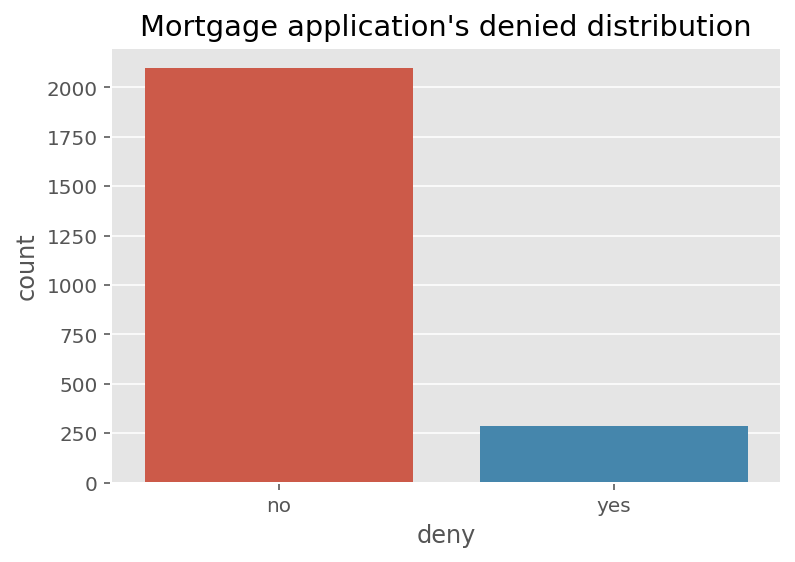

In [6]:
#print value counts
print(df.deny.value_counts())

#get separate counts for each response value to see %
count_no_denied = len(df[df['deny']=='no'])
count_denied = len(df[df['deny']=='yes'])

pct_of_no_deny = count_no_denied/(count_no_denied+count_denied)
print("percentage of no mortage deny is", pct_of_no_deny*100)
pct_of_deny = count_denied/(count_no_denied+count_denied)
print("percentage of deny", pct_of_deny*100)
sns.countplot(x = 'deny', data = df).set_title("Mortgage application's denied distribution")

Our classes are imbalanced, and the ratio of no-denied to denied mortgage application to instances is 88:12. By simply predicting "do not deny" for each applicant we could achieve a training model accuracy of 88%. This metric is referred to as the null error rate. Before we go ahead to balance the classes, let’s do some more exploration.

### EDA on Numeric Features

In [7]:
df.groupby('deny').mean()

,debt_pymt_income_ratio,house_expen_income_ratio,loan_size_prop_value_ratio,cons_cred_score,mort_cred_score,unemp_rate_app_industry,unit_condo
deny,,,,,,,
no,0.322933,0.250605,0.727070,1.955208,1.699294,3.741925,0.281489
yes,0.388771,0.290212,0.816379,3.301754,1.880702,4.014035,0.336842


We can see that on average, people that get their mortgage application denied have higher:
- debt payments to total income ratio, suggesting that if their income is higher than the debts then this ratio is smaller, and then more likely to get an approved application. 
- housing expenses to income ratio, makes sense, same logic as above.
- ratio of size of loan to assessed value of property, suggesting that more money the applicant requests in comparison to the property value, then the bigger will be this ratio, hence the more likely to be denied.
- consumer credit score, even though this is categorical, it makes sense since a low score is better according to the data dictionary.
- mortgage credit score, makes sense, same logic as above.

Now we will look at the correlations between numeric explanatory variables to detect initial collinearity.

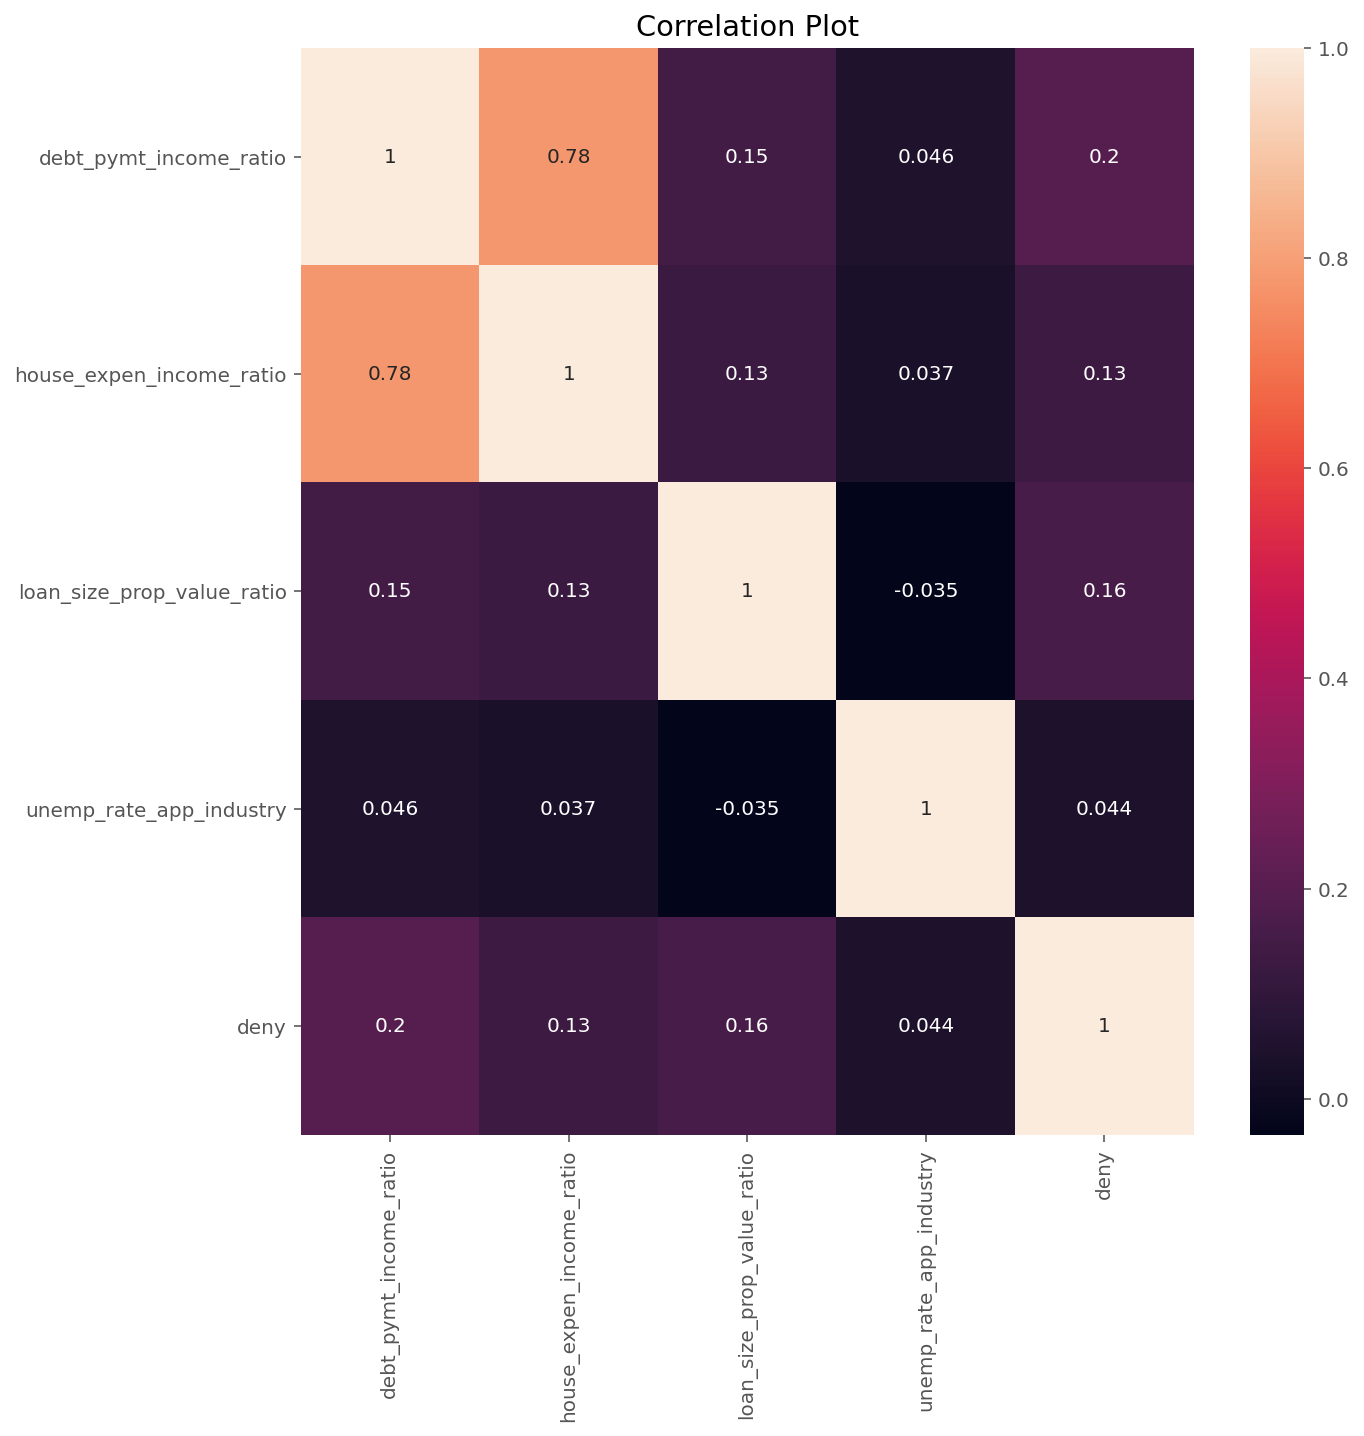

In [8]:
# initial correlation
df.deny.replace(["no", "yes"], [0, 1], inplace = True)
numeric.append('deny')
cor = df[numeric].corr()
plt.figure(figsize=(10,10))
plt.title("Correlation Plot")
sns.heatmap(cor,annot=True)
plt.show()

We can see that 'debt_pymt_income_ratio' and 'house_expen_income_ratio' show a correlation of 0.78 suggesting that there might be some collinearity between both variables. Hence, we can keep only one in our analysis.

Looking at the features distributions below we can see the values that each one has and to assess for potential outliers.

In [9]:
df.deny.replace([0, 1], ["no", "yes"], inplace = True)
numeric.remove('deny')

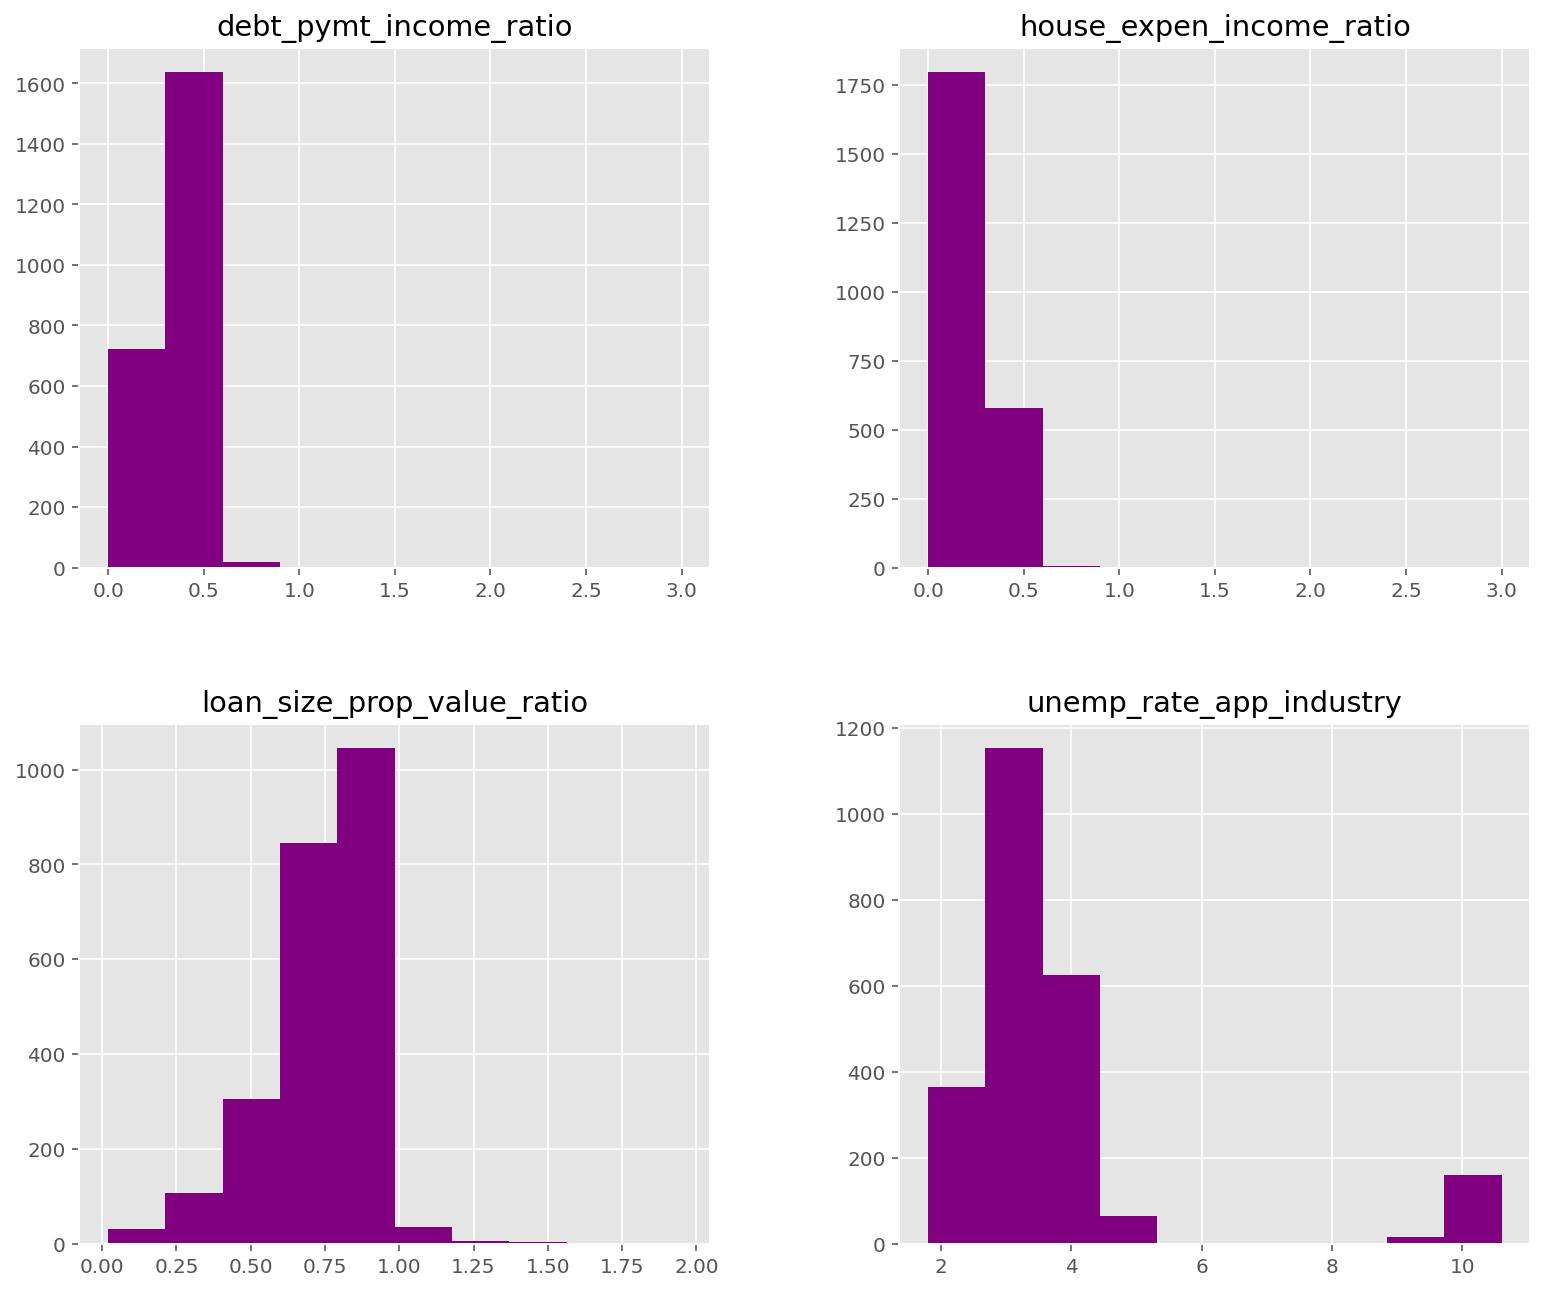

In [10]:
df[numeric].hist(figsize=(13, 11), color='purple');
plt.show();

Below we show each of the numeric variables and the association with the response. Part of the code below was extracted from Project 1 created by Sara, Rachel and Michael. <br>
https://yu.instructure.com/courses/42423/files/1389305/download?wrap=1

We added the response in the horizontal axis (x="deny") to allow a comparison and extract potential predictive features.

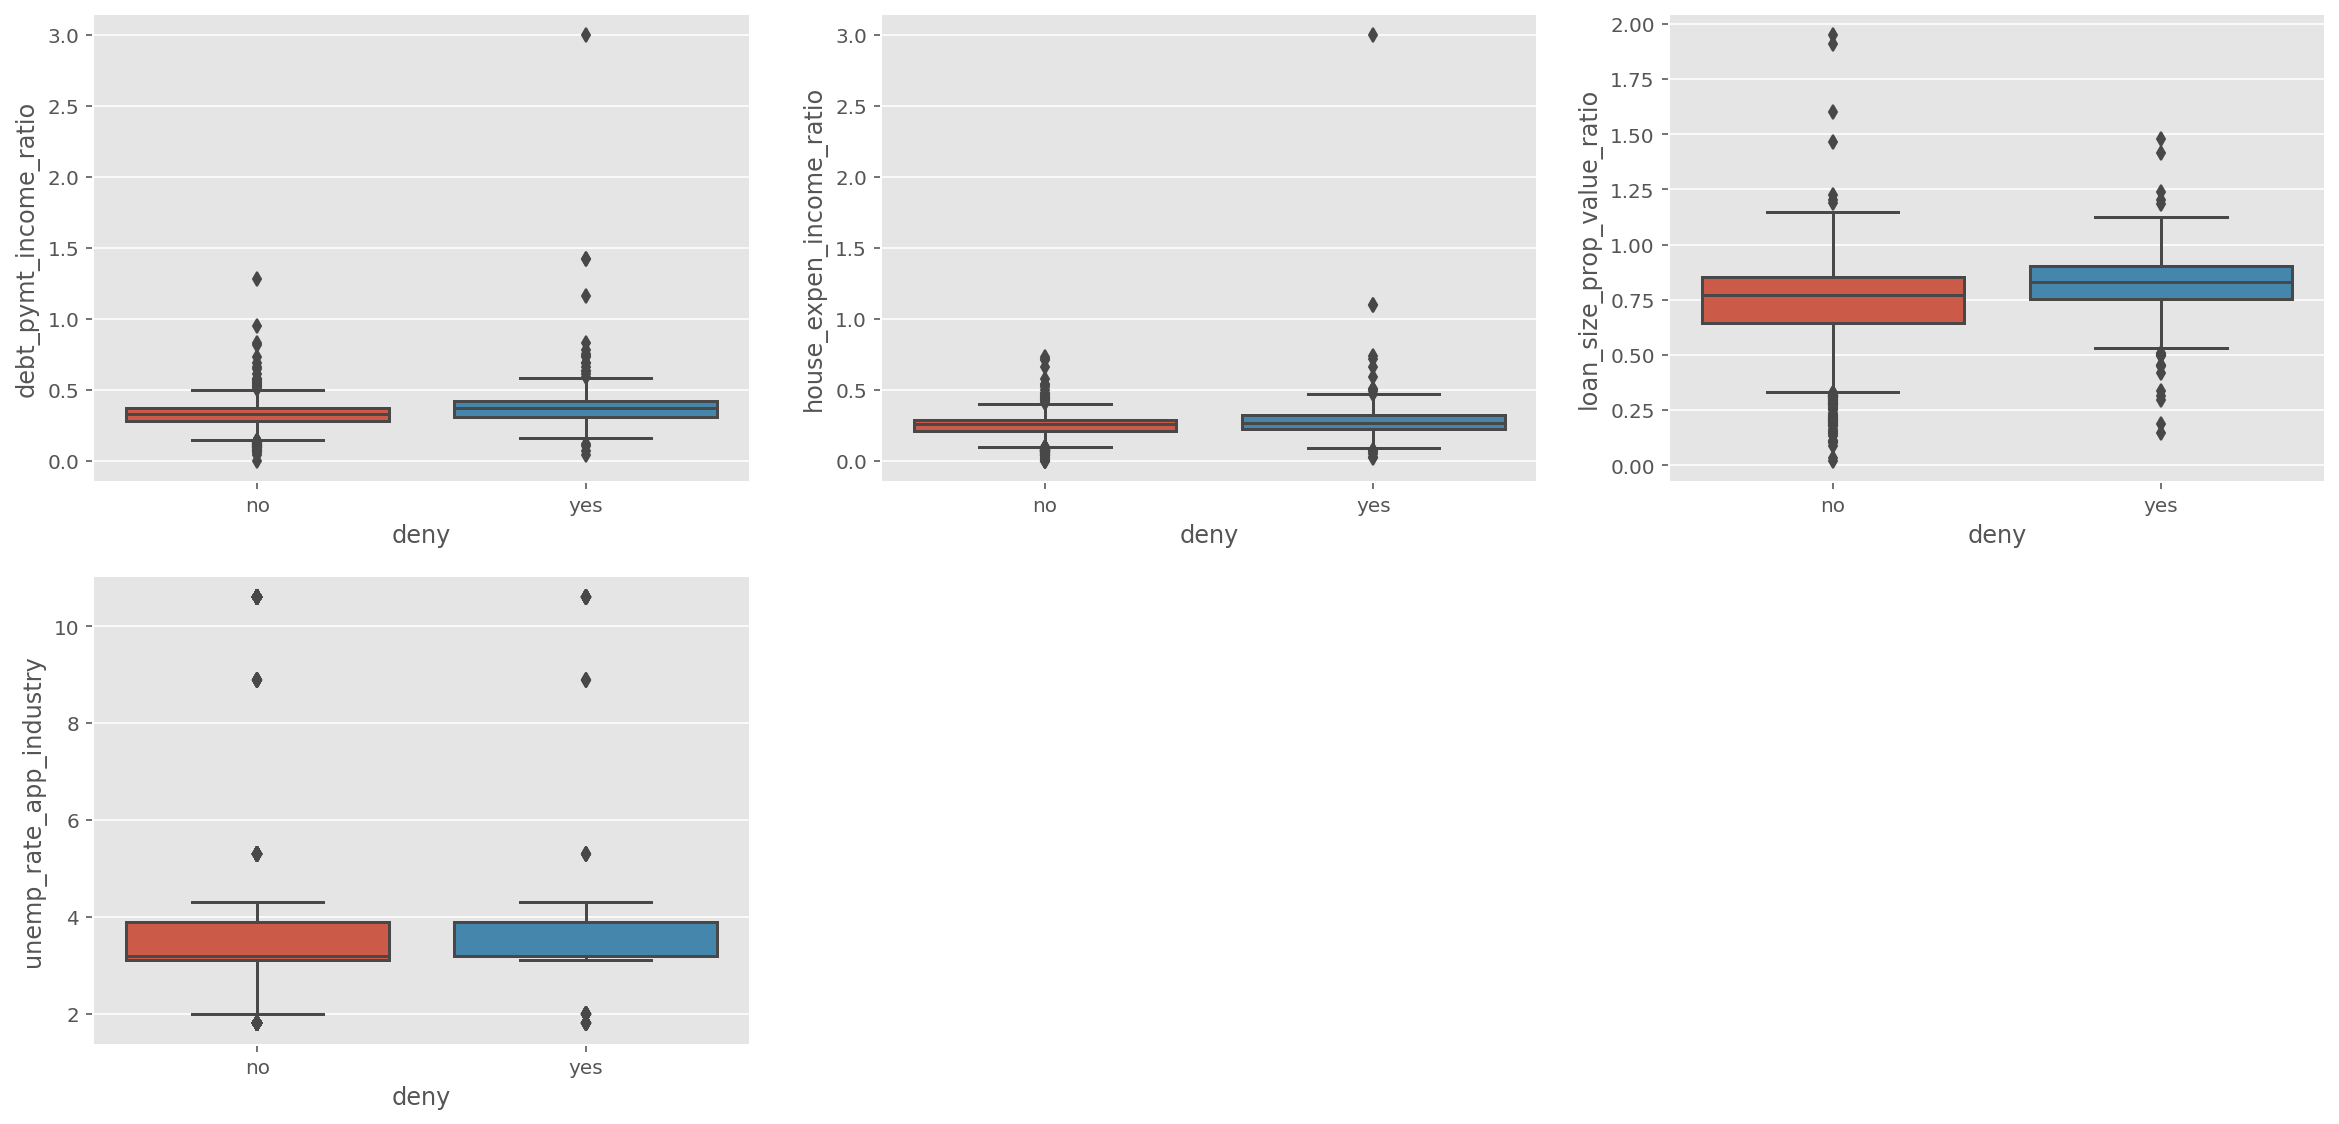

In [11]:
#define a figure to which we will add boxplots of each attribute.
plt.figure(figsize=(20,25))

#use an index to identify the spot of the subplot
j=1
columns=df[numeric].columns.tolist()
for k in columns:   #for each numeric column in the dataframe
    plt.subplot(5,3,j) 
    sns.boxplot(x="deny", y=k,data=df)
    j=j+1 #add 1 to go to the next subplot space

#show results
plt.show();

From the boxplots we can see __'loan_size_prop_value_ratio'__ to be a potential good predictor as the boxplot is slightly higher for the main IQR for applications that get denied. Below we do some analysis on the potential outliers for this feature.

In [12]:
#creating a list for potential predictors
predictors = []
predictors.append('loan_size_prop_value_ratio')
predictors.append('debt_pymt_income_ratio')

### EDA on Categorical features

Below we plot our response variable vs each of the categorical features

Text(0, 0.5, 'Frequency of Mortgages')

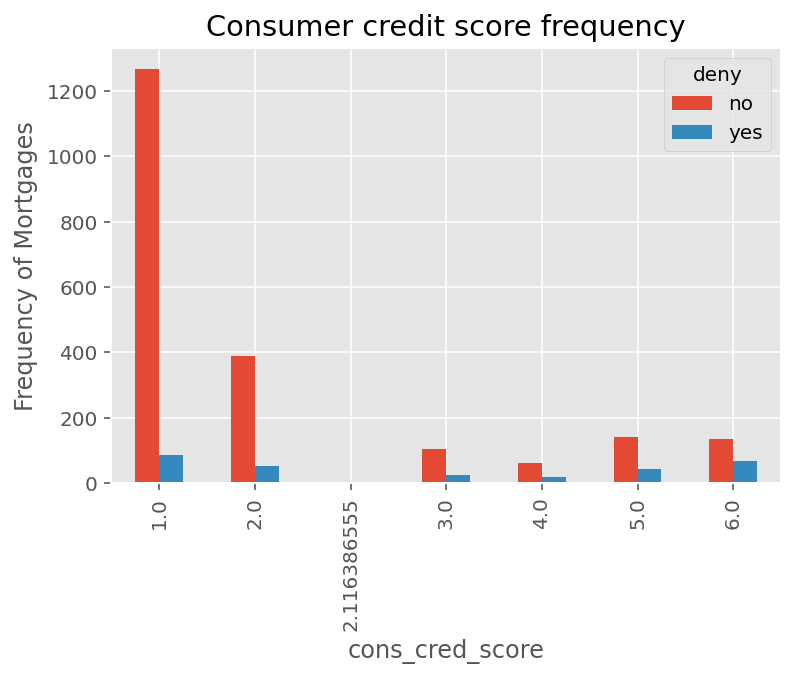

In [13]:
#consumer credit score
pd.crosstab(df.cons_cred_score,df.deny).plot(kind='bar');
plt.title('Consumer credit score frequency')
plt.xlabel('cons_cred_score')
plt.ylabel('Frequency of Mortgages')

The 'consumer credit score' status seem a strong predictor for the outcome variable. Hence we add it in our list.
According to the data dictionary the lower the score the better, and in this case 1 and 2 show more chances of getting the mortgage approved.

In [14]:
predictors.append('cons_cred_score')

Text(0, 0.5, 'Frequency of Mortgages')

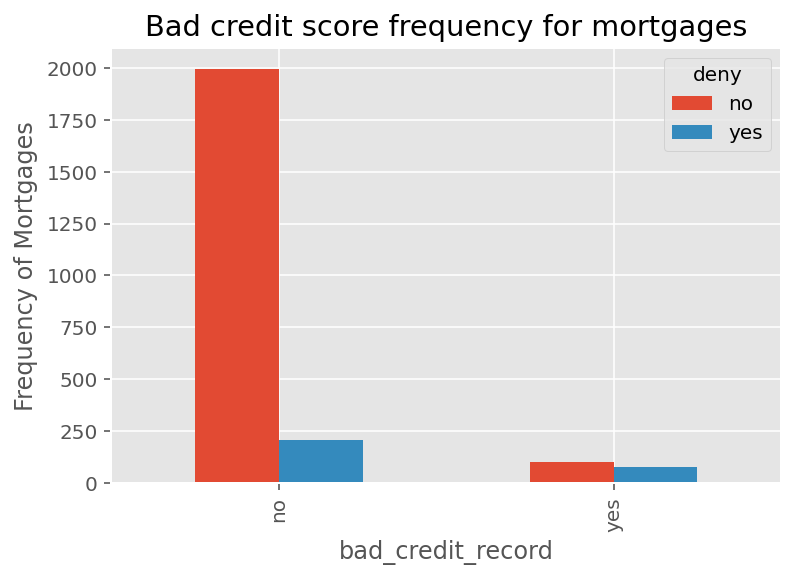

In [15]:
#public bad credit record 
pd.crosstab(df.bad_credit_record,df.deny).plot(kind = 'bar');
plt.title('Bad credit score frequency for mortgages')
plt.xlabel('bad_credit_record')
plt.ylabel('Frequency of Mortgages')

The 'bad_credit_record' status seem a strong predictor for the outcome variable. Hence we add it in our list. We see that if the applicant does not have a bad credit record is very unlikely that it will be rejected.

In [16]:
predictors.append('bad_credit_record')

Text(0, 0.5, 'Frequency of Mortgages')

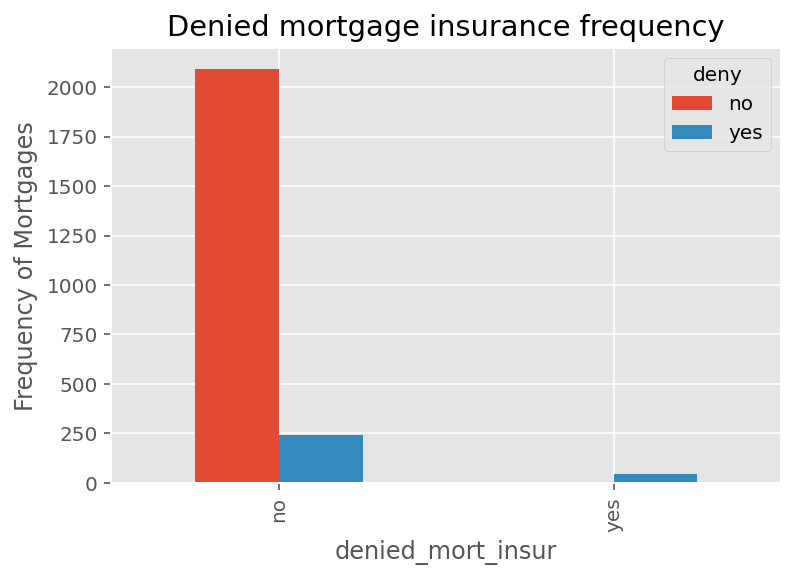

In [17]:
# denied mortgage insurance
pd.crosstab(df.denied_mort_insur,df.deny).plot(kind='bar');
plt.title('Denied mortgage insurance frequency')
plt.xlabel('denied_mort_insur')
plt.ylabel('Frequency of Mortgages')

The frequency of mortgages depends a great deal on the public credit record. Thus, the public bad credit record can be a good predictor of the outcome variable.

Text(0, 0.5, 'Frequency of Mortgages')

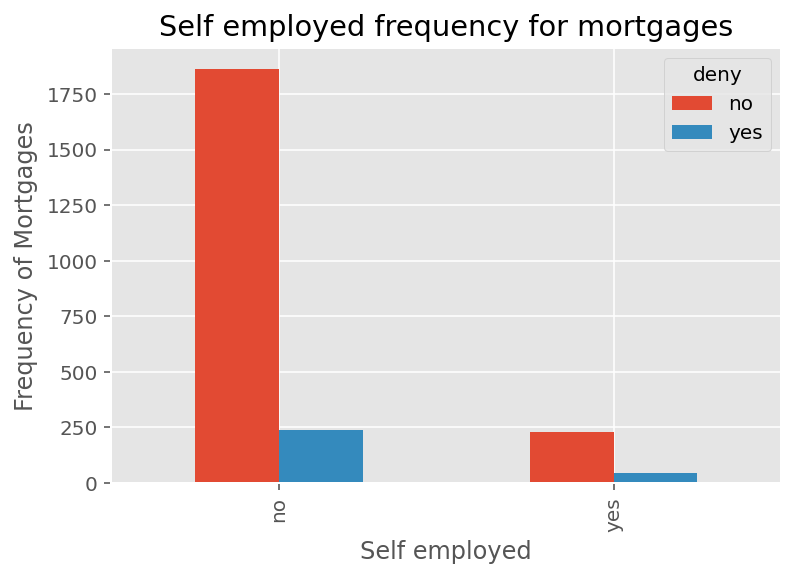

In [18]:
predictors.append('denied_mort_insur')

#self employed 
pd.crosstab(df.self_emp,df.deny).plot(kind='bar');
plt.title('Self employed frequency for mortgages')
plt.xlabel('Self employed')
plt.ylabel('Frequency of Mortgages')

The self employed status seem a strong predictor for the outcome variable.

Text(0, 0.5, 'Frequency of Mortgages')

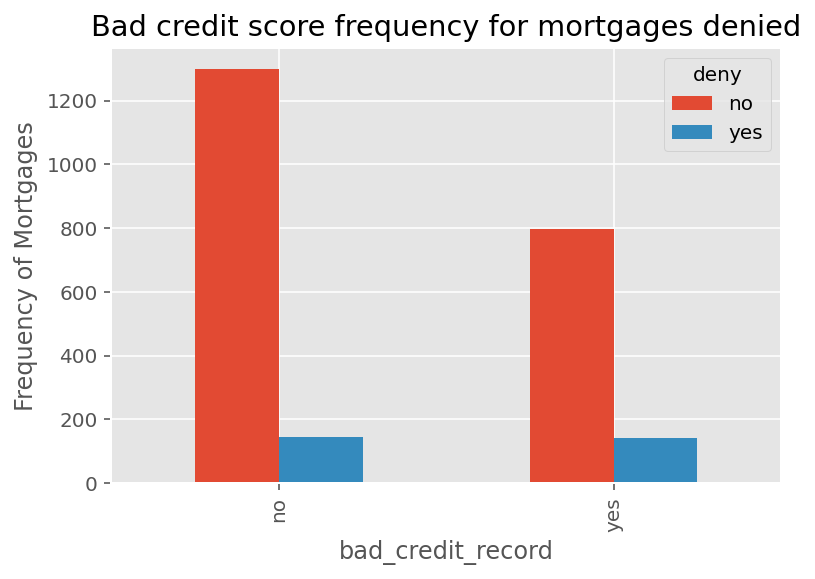

In [19]:
predictors.append('self_emp')

#is the applicant single 
pd.crosstab(df.single,df.deny).plot(kind='bar');
plt.title('Bad credit score frequency for mortgages denied')
plt.xlabel('bad_credit_record')
plt.ylabel('Frequency of Mortgages')

The single status does not seem a strong predictor for the outcome variable.

Text(0, 0.5, 'Frequency of Mortgages')

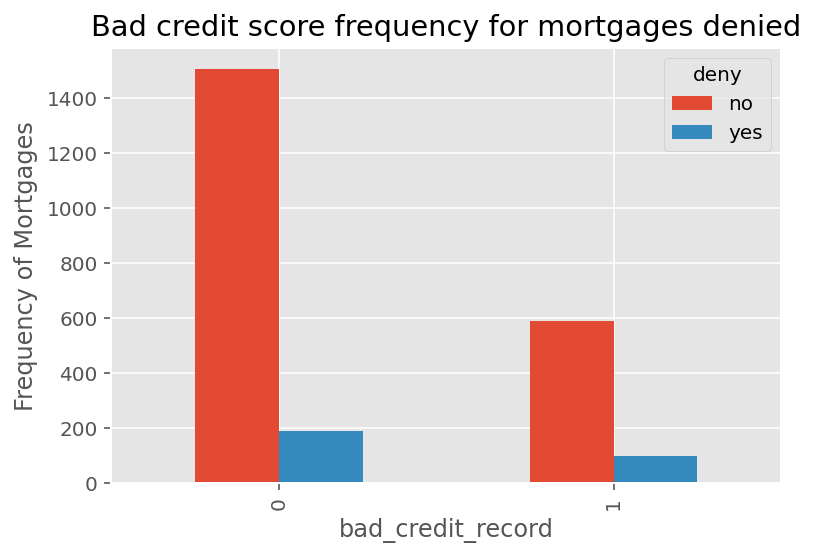

In [20]:
#is unit a condominium 
pd.crosstab(df.unit_condo,df.deny).plot(kind='bar');
plt.title('Bad credit score frequency for mortgages denied')
plt.xlabel('bad_credit_record')
plt.ylabel('Frequency of Mortgages')

The unit being a condo can potentially be a good predictor, but it is not so clear.

Text(0, 0.5, 'Frequency of Mortgages')

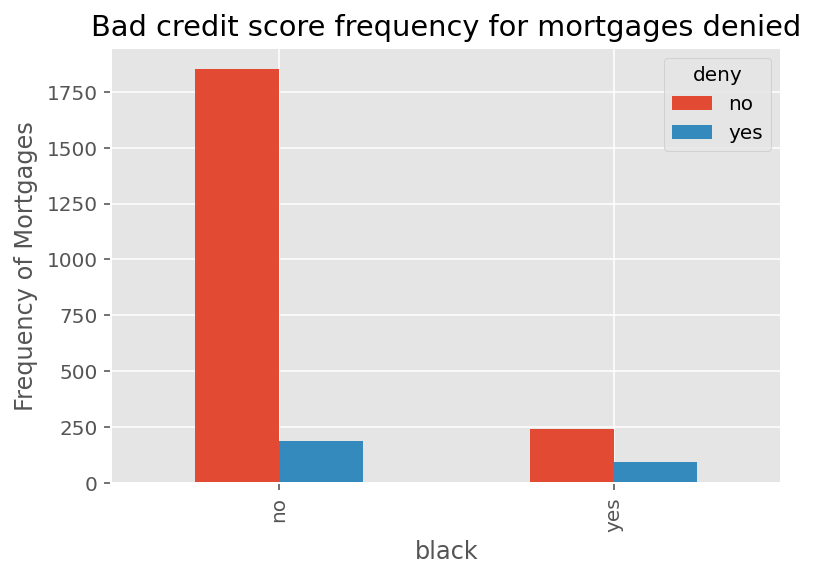

In [21]:
#is the applicant black 
pd.crosstab(df.black,df.deny).plot(kind='bar');
plt.title('Bad credit score frequency for mortgages denied')
plt.xlabel('black')
plt.ylabel('Frequency of Mortgages')

The black status does not seem a strong predictor for the outcome variable.

Text(0, 0.5, 'Frequency of Mortgages')

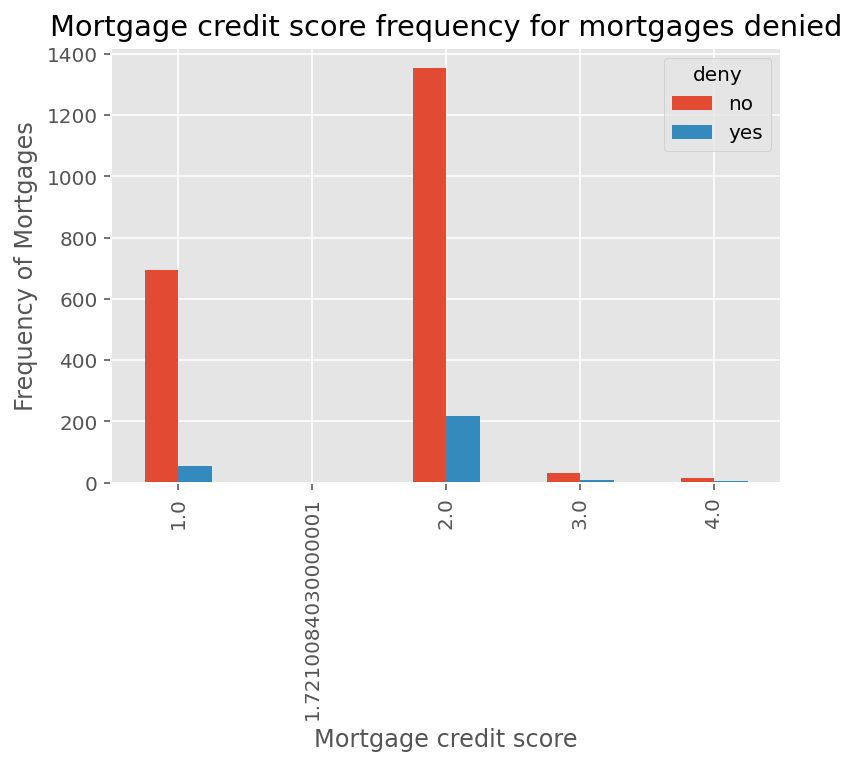

In [22]:
#mortage credit score
pd.crosstab(df.mort_cred_score,df.deny).plot(kind='bar');
plt.title('Mortgage credit score frequency for mortgages denied')
plt.xlabel('Mortgage credit score')
plt.ylabel('Frequency of Mortgages')

Mortgage credit score does not seem to be a good predictor.

In [23]:
predictors

['loan_size_prop_value_ratio',
 'debt_pymt_income_ratio',
 'cons_cred_score',
 'bad_credit_record',
 'denied_mort_insur',
 'self_emp']

# Data Preparation

Describe + show the steps you have taken to address the data integrity + usability issues you identified in your EDA, including any feature engineering techniques you have applied to the data set. This section should include any Python code used for Data Preparation.

## Deleting null values

In [24]:
#exclude the only record with null values
df = df.dropna()
df.shape

(2380, 13)

In [25]:
numeric

['debt_pymt_income_ratio',
 'house_expen_income_ratio',
 'loan_size_prop_value_ratio',
 'unemp_rate_app_industry']

## Excluding Outliers

According to Investopedia the highest that company will usually lend 43% while private investors have been known to lend  on up to 55% DTI. However, there is no limit on a DTI. In theory a person can have a DTI higher than 100%. So no outliers can be removed using domain knowledge. 
https://www.investopedia.com/terms/d/dti.asp
https://dreamhomefinancing.com/high-dti-mortgage-lenders/

According to Bankrate.com the highest a house expense to income ratio can go is 28% with exceptions for people with good credit and other factors. However Since the data has few observations past 28% we cannot eliminate any of these observations as they can be valid numbers.
https://www.bankrate.com/glossary/h/housing-expense-ratio/

The highest Loan to value ratio is normally 97%, however an application can have ratio on it with no limit. As such we cannot eliminate any of the observations in this attribute.
https://www.investopedia.com/terms/l/loantovalue.asp

In the unemployment rate field all of the values are valid numbers and we cannot exclude any of them. The rest of the fields in this study are categorical and do not have any outliers.

## Over-sampling using SMOTE

Considering the imbalance class in the response we need to find a way to make the 2 outcomes somewhat even. With our training data created, I’ll up-sample the no-deny using the SMOTE algorithm(Synthetic Minority Oversampling Technique). At a high level, SMOTE: 

- Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
- Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [26]:
#first we replace 'no' with zero and 'yes' with 1
df.bad_credit_record.replace(["no", "yes"], [0, 1], inplace = True)
df.denied_mort_insur.replace(["no", "yes"], [0, 1], inplace = True)
df.self_emp.replace(["no", "yes"], [0, 1], inplace = True)
df.single.replace(["no", "yes"], [0, 1], inplace = True)
df.black.replace(["no", "yes"], [0, 1], inplace = True)
df.deny.replace(["no", "yes"], [0, 1], inplace = True)

# Splitting into predictors and response.
X = df.loc[:, df.columns != 'deny']
y = df.loc[:, 'deny']

# Balancing
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Columns
columns = X_train.columns

# Split and balance
os_data_X, os_data_y = os.fit_sample(X_train, y_train)

# Changing 
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y = pd.DataFrame(data=os_data_y,columns=['deny'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['deny']==0]))
print("Number of subscription",len(os_data_y[os_data_y['deny']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['deny']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['deny']==1])/len(os_data_X))

length of oversampled data is  2926
Number of no subscription in oversampled data 1463
Number of subscription 1463
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


After applying SMOTE, we then have a balanced class, and considering our target variable is a binary categorical feature, the null error rate for the data that includes the synthesized observations is now .50. With a .50 null error rate, an accuracy metric can be a very effective tool for comparing models.

In [27]:
# Making a copy of the last original data frame.
df2 = os_data_X.copy()
df2['deny'] = os_data_y

## Feature Selection.

Despite having preformed EDA we have decided to apply some feature selection methods to explore other features and experiment on whether or not they were better than the choices we made based off our EDA.

### Univariate.

In univariate feature selection, we will use SelectKBest that removes all but the k highest scoring features. This is according to the sklearn documentation.

http://scikitlearn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier

# find best scored 5 features
select_feature = SelectKBest(chi2, k=4).fit(df2[categorical],df2['deny'])

# Created a dictionary.
dic = {}
for score, name in zip(select_feature.scores_,df2[categorical].columns):
    dic[name] = score
    
# Sorting the dictionary.
dic = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)}
dic

{'cons_cred_score': 505.1686250643275,
 'denied_mort_insur': 111.29268292682927,
 'bad_credit_record': 93.88339222614842,
 'black': 79.06262230919765,
 'self_emp': 33.6695652173913,
 'mort_cred_score': 15.115659414080996,
 'unit_condo': 4.651162790697675,
 'single': 1.1172413793103448}

We have chosen the top 4 predictive categorical features because they have the highest scores and anything below that was not significant enough to include. Because of this we only included 4 of the categorical variables in addition to a numerical variable that we have deemed to be potentially predictive relying on the information we obtained from the EDA prior to this section.

In [29]:
predictors

['loan_size_prop_value_ratio',
 'debt_pymt_income_ratio',
 'cons_cred_score',
 'bad_credit_record',
 'denied_mort_insur',
 'self_emp']

In [30]:
predictors2 = ['cons_cred_score', 'denied_mort_insur', 'bad_credit_record', 'black', 'loan_size_prop_value_ratio'] #'black is the only difference'

### 2 sets of predictors

In [31]:
predictors # Obtained from EDA

['loan_size_prop_value_ratio',
 'debt_pymt_income_ratio',
 'cons_cred_score',
 'bad_credit_record',
 'denied_mort_insur',
 'self_emp']

In [32]:
predictors2 # Obtained from Univariate feature selection with selectKbest and ChiSquared.

['cons_cred_score',
 'denied_mort_insur',
 'bad_credit_record',
 'black',
 'loan_size_prop_value_ratio']

### Standarize only numeric features

Considering the recommended approach for both KNN and SVM is to have Standarize data, we will apply the procedure to our dataframe using ColumnTransformer, and considering we only want to input to numeric features, we set the order of the columns at the beginning so that the rest of the columns get appended at the right of the numeric with the 'passthrough' parameter.

In [33]:
#reorder columns to have numeric first, then categorical, and the response at the end.
df = df[numeric + categorical + ['deny']]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric)],
        remainder='passthrough')

clf = make_pipeline(preprocessor)
scaled_df = clf.fit_transform(df)
df = pd.DataFrame(scaled_df, columns=df.columns)
df.head(1)

,debt_pymt_income_ratio,house_expen_income_ratio,loan_size_prop_value_ratio,unemp_rate_app_industry,bad_credit_record,denied_mort_insur,self_emp,single,unit_condo,black,cons_cred_score,mort_cred_score,deny
0,-1.024048,-0.35542,0.348178,0.061927,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0


In [34]:
#reorder columns to have numeric first, then categorical, and the response at the end.
df2 = df2[numeric + categorical + ['deny']]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric)],
        remainder='passthrough')

clf = make_pipeline(preprocessor)
scaled_df = clf.fit_transform(df2)
df2 = pd.DataFrame(scaled_df, columns=df2.columns)
df2.head(1)

,debt_pymt_income_ratio,house_expen_income_ratio,loan_size_prop_value_ratio,unemp_rate_app_industry,bad_credit_record,denied_mort_insur,self_emp,single,unit_condo,black,cons_cred_score,mort_cred_score,deny
0,-0.160749,0.184133,0.173327,0.174537,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0


# Prepped Data Review

Considering we have changes on the entire dataset with the over-sampling, we will rerun the EDA on all of them, focusing on the ones we selected as promising predictors.

### Numerical Features

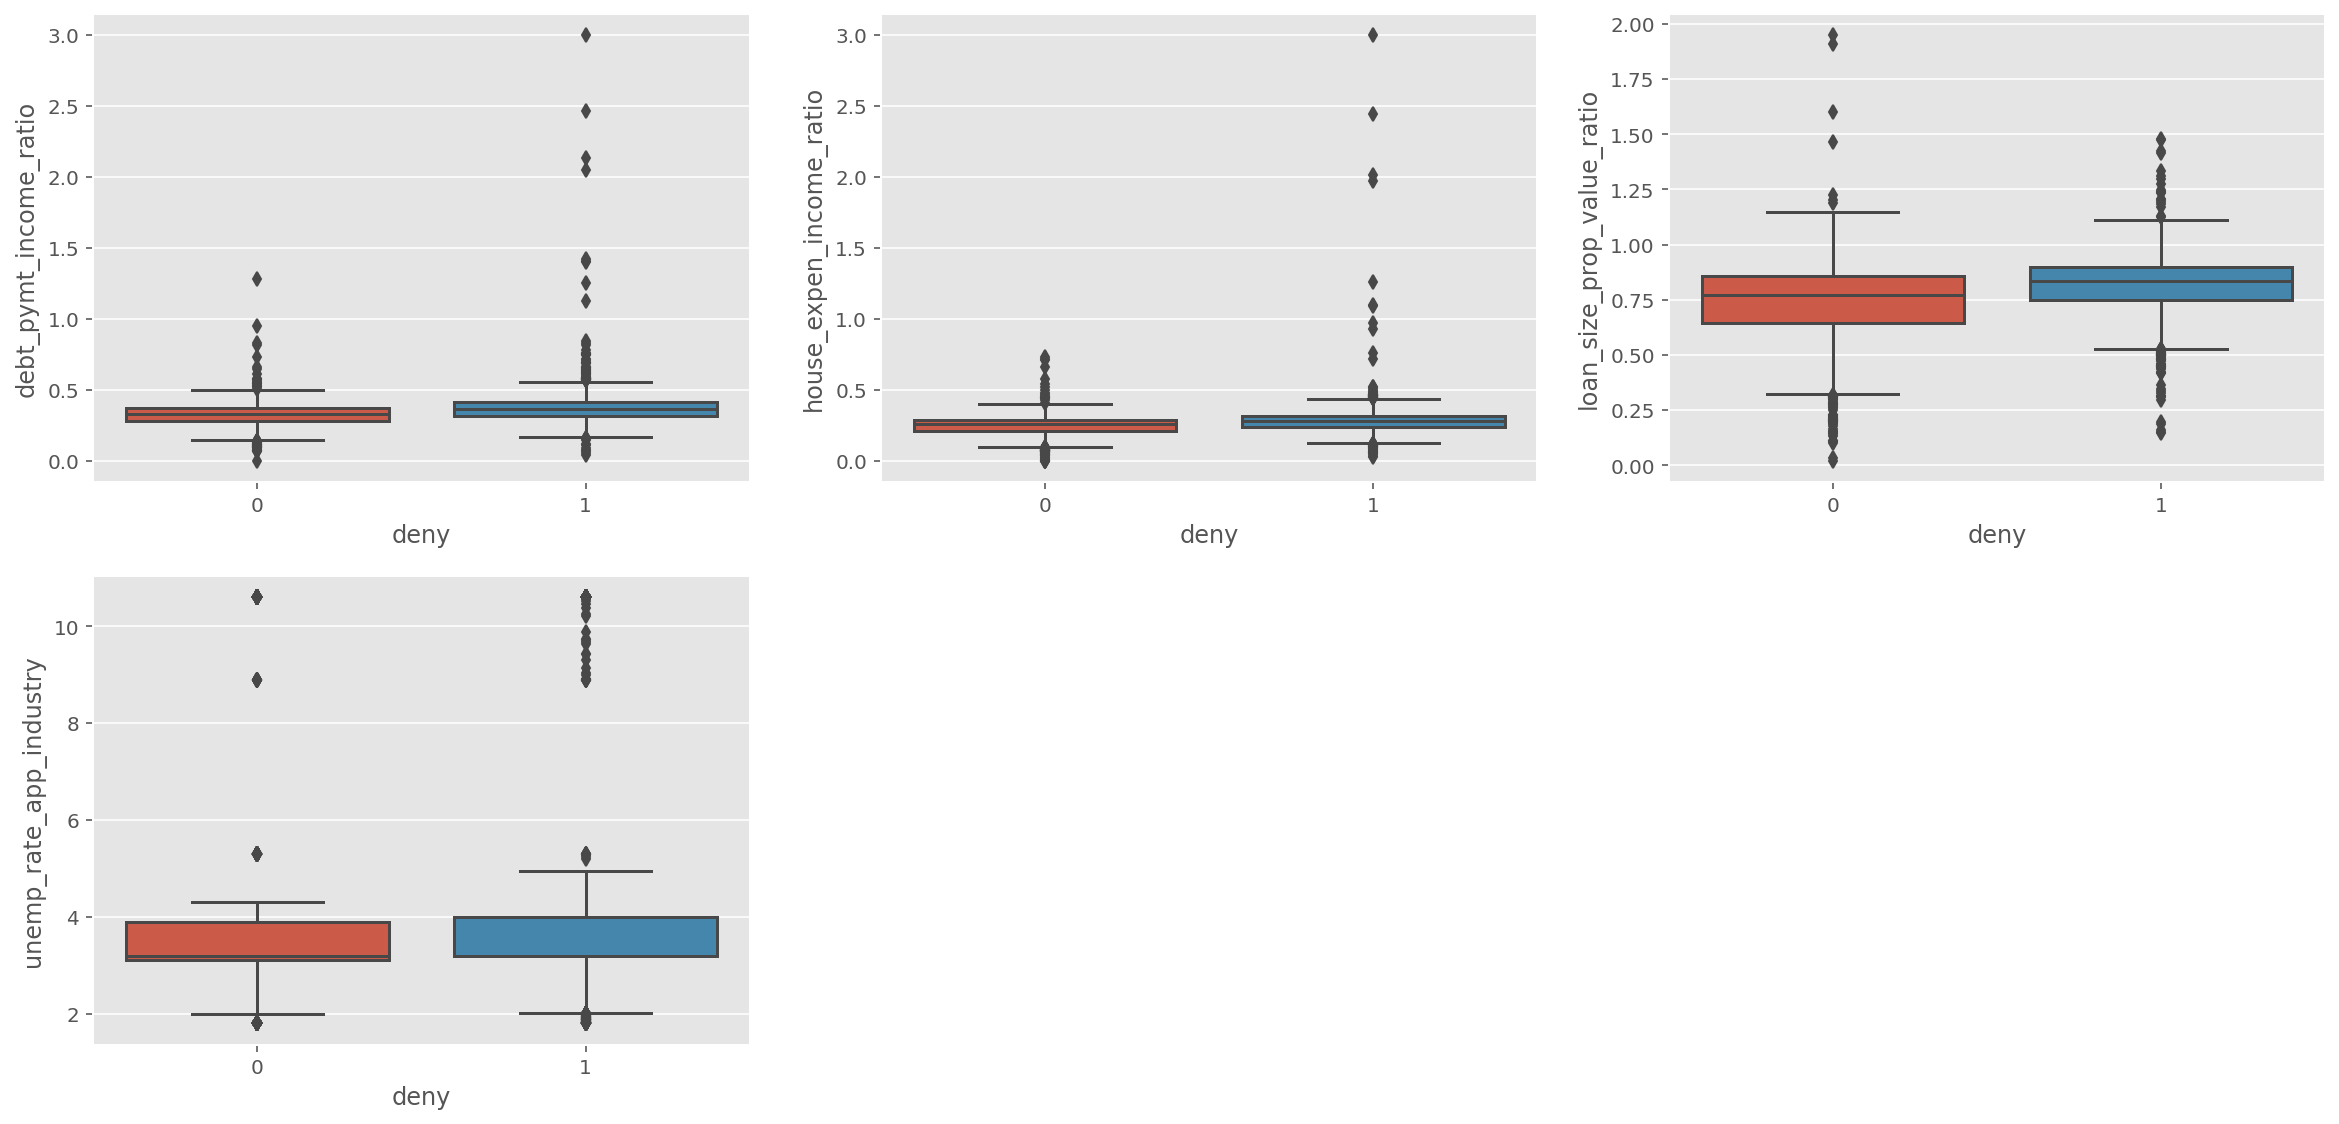

In [33]:
#define a figure to which we will add boxplots of each attribute.
plt.figure(figsize=(20,25))

#use an index to identify the spot of the subplot
j = 1

# Columns
columns = df2[numeric].columns.tolist()

for k in columns:   #for each numeric column in the dataframe
    plt.subplot(5,3,j) 
    sns.boxplot(x = "deny", y = k,data = df2)
    j = j + 1 #add 1 to go to the next subplot space

#show results
plt.show();

We can see that __loan_size_prop_value_ratio__ is still a promising predictor.

In [34]:
#rounding decimal numbers for consumer credit score
df2 = df2.round({'cons_cred_score': 0})
df2 = df2.round({'mort_cred_score': 0})

Text(0, 0.5, 'Frequency of Mortgages')

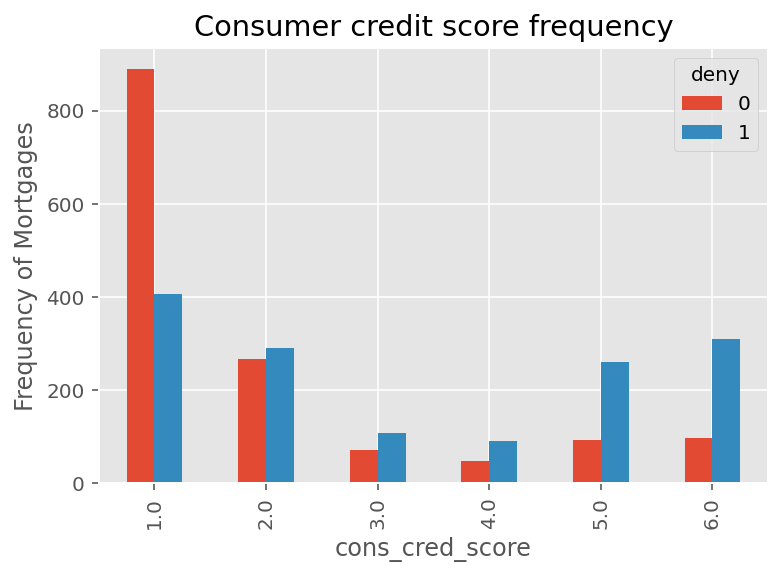

In [35]:
#consumer credit score
pd.crosstab(df2.cons_cred_score,df2.deny).plot(kind='bar');
plt.title('Consumer credit score frequency')
plt.xlabel('cons_cred_score')
plt.ylabel('Frequency of Mortgages')

We can see that __Consumer credit score__ is still a promising predictor.

Text(0, 0.5, 'Frequency of Mortgages')

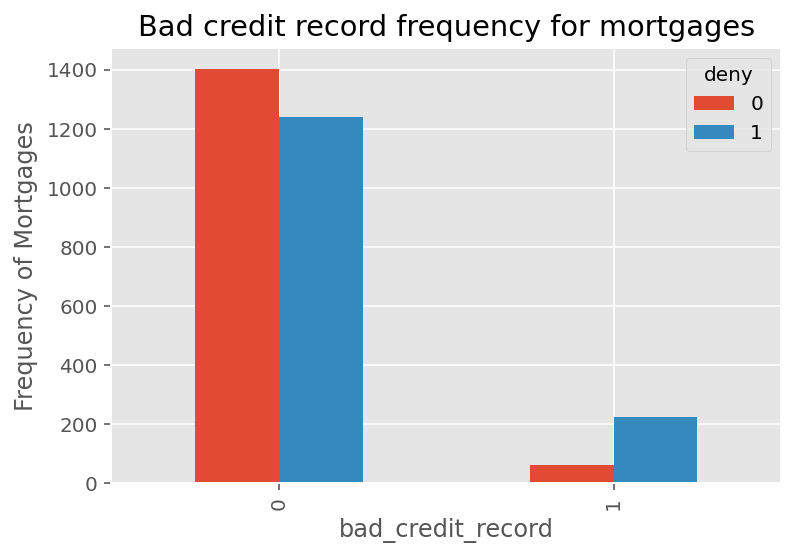

In [36]:
#public bad credit record 
pd.crosstab(df2.bad_credit_record,df2.deny).plot(kind = 'bar');
plt.title('Bad credit record frequency for mortgages')
plt.xlabel('bad_credit_record')
plt.ylabel('Frequency of Mortgages')

We can see that __Bad credit records__ is still a promising predictor.

Text(0, 0.5, 'Frequency of Mortgages')

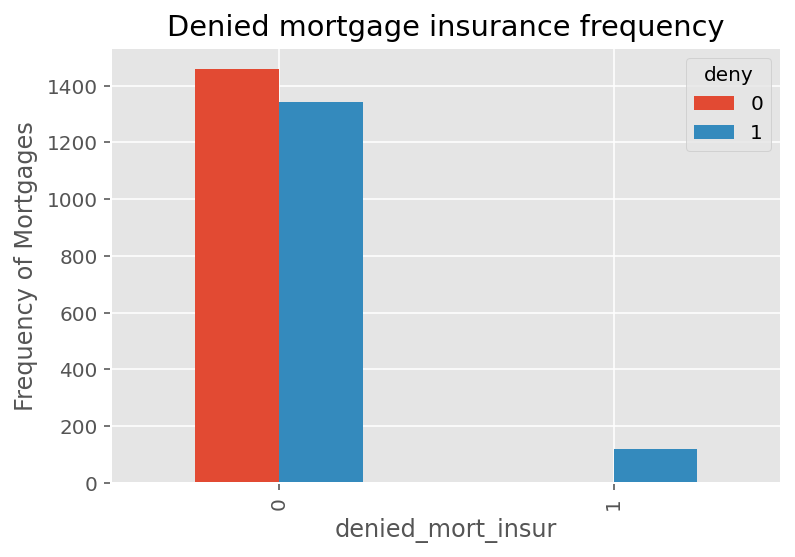

In [37]:
# denied mortgage insurance
pd.crosstab(df2.denied_mort_insur,df2.deny).plot(kind='bar');
plt.title('Denied mortgage insurance frequency')
plt.xlabel('denied_mort_insur')
plt.ylabel('Frequency of Mortgages')

We can see that __Denied mortgage insurance__ is still a strong predictor.

Text(0, 0.5, 'Frequency of Mortgages')

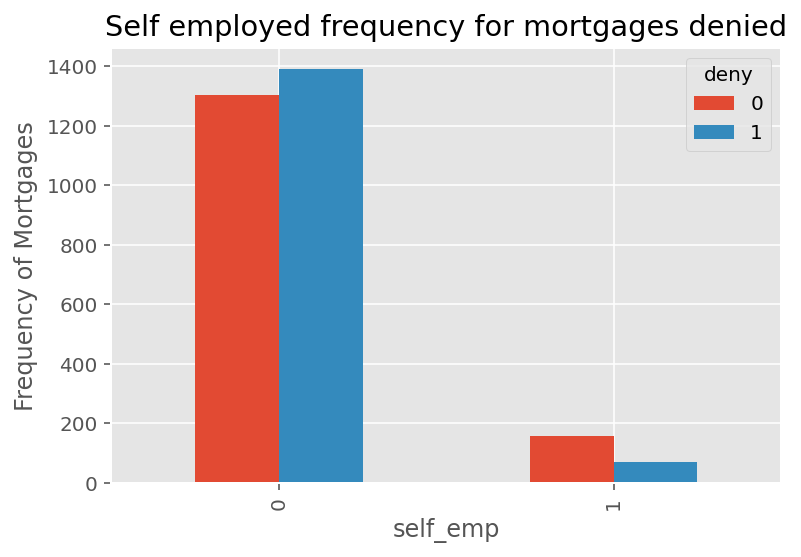

In [38]:
#is the applicant black 
pd.crosstab(df2.self_emp,df2.deny).plot(kind='bar');
plt.title('Self employed frequency for mortgages denied')
plt.xlabel('self_emp')
plt.ylabel('Frequency of Mortgages')

We can see that __self employed__ is still a good predictor.

Text(0, 0.5, 'Frequency of Mortgages')

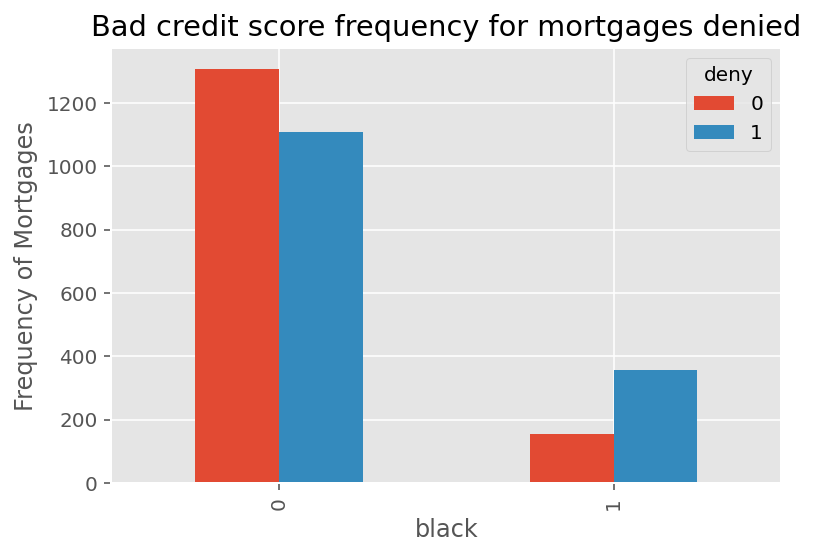

In [39]:
#is the applicant black 
pd.crosstab(df2.black,df2.deny).plot(kind='bar');
plt.title('Bad credit score frequency for mortgages denied')
plt.xlabel('black')
plt.ylabel('Frequency of Mortgages')

We can see that __black__ now appears to be a good predictor.

Text(0, 0.5, 'Frequency of Mortgages')

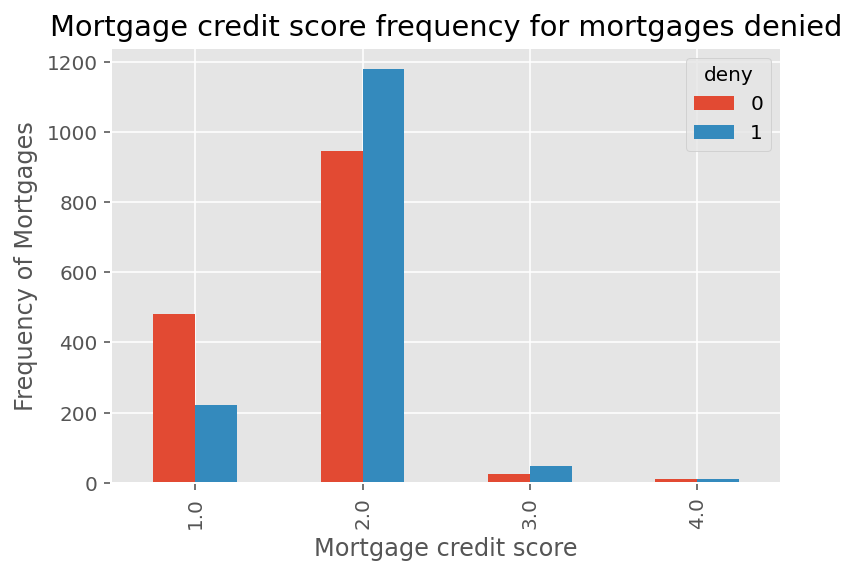

In [40]:
#mortage credit score
pd.crosstab(df2.mort_cred_score,df2.deny).plot(kind='bar');
plt.title('Mortgage credit score frequency for mortgages denied')
plt.xlabel('Mortgage credit score')
plt.ylabel('Frequency of Mortgages')

Despite the fact that the model seems to be a good predictor in theory, it is however not as valuable in practice as we will see later on that it was not included in our Classifiers.

# KNN + SVM Modeling

In this section we will create 3 KNN first and then  3 SVM models as below:
- 1st KNN and 1st SVM using the dataframe without oversampling
- 2nd NKK and 2nd SVM using oversampling + 1st set of features
- 3rd NKK and 3rd SVM using oversampling + 2nd set of features.

We will make use of gridsearch and cross-validation to find the best parameters for each one. Some of the techniques were gathered from the course materials and the following links.

https://medium.com/@svanillasun/how-to-deal-with-cross-validation-based-on-knn-algorithm-compute-auc-based-on-naive-bayes-ff4b8284cff4
https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a

## Approach for KNN Models
To apply KNN we need to Select the best value for 'k' for the optimal number of neighbors and 'd' for the distance metric, so we can create the training and testing set and conduct cross-validation on the training set, for a variety of different values of 'k' and 'd', searching for the combination that gives the best performance on the training data.

We define a function that will create a plot using every cross-validation value and then GridSearch to test for every combination of neighbors and with distance 1 (Manhattan) and 2 (Euclidean).

In [42]:
def cross_validate_knn(X,y, metric_param):
    """Function that chooses the best k (between 1 and 31)
    for a given training set and metric parameter"""

    k_range = range(1, 25)
    k_scores = []
    # use iteration to calculate  different k in models, then return the average accuracy based on the cross validation
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=5, scoring=metric_param)
        k_scores.append(scores.mean())
        
    # plot to see clearly
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated ' + metric_param + ' Score')
    plt.show()

    #perform gridsearch to get highest score
    knn2 = KNeighborsClassifier()#create a dictionary of all values we want to test for n_neighbors
    param_grid = {'n_neighbors': np.arange(1, 31), 'p': np.arange(1, 3)}#use gridsearch to test all values for n_neighbors
    knn_gscv = GridSearchCV(knn2, param_grid, cv=5, scoring = metric_param)#fit model to data
    knn_gscv.fit(X, y)
    

    #check top performing n_neighbors value
    print('top performing n_neighbors value ',knn_gscv.best_params_)
    #check mean score for the top performing value of n_neighbors
    print('top performing n_neighbors score ',knn_gscv.best_score_)
    
    return (knn_gscv.best_params_)

### KNN - Model 1

As model 1 will have an imbalanced distribution in the response variable we will use scoring = 'f1' for cross-validation.

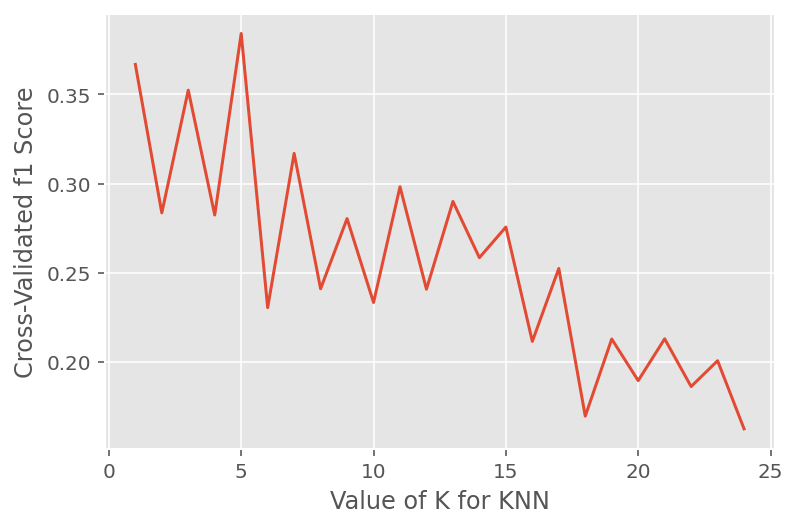

top performing n_neighbors value  {'n_neighbors': 5, 'p': 2}
top performing n_neighbors score  0.3841635184523021


In [43]:
#model 1 with EDA features
X = df[predictors]
y = df['deny']

#creating train and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

best_params = cross_validate_knn(X_train, y_train, 'f1')
best_k = best_params['n_neighbors']
best_distance = best_params['p']

The graph and gridsearch shows the best value for 'k' is 5 and the best distance to be 2 (Euclidean). We can see that KNN is highly impacted by the imbalance class. We will create another KNN on the dataframe that had classes balanced using SMOTE. 
Below we store the metrics of this first model, to compare it with the rest.
Below we fit our model with the best parameters and then add the metrics to a set of lists for a better understanding of all the 6 models together at the end.

In [44]:
# use the same model as before
knn_1 = KNeighborsClassifier(n_neighbors = best_k, p = best_distance)
knn_1.fit(X_train,y_train)

# Cross validation.
accuracy_list = []
recall_list = []
auc_list = []
f1_list = []
precision_list = []

accuracy = cross_val_score(knn_1, X_train, y_train, scoring = "accuracy", cv = 5)
recall = cross_val_score(knn_1, X_train, y_train, scoring = "recall", cv = 5)
auc = cross_val_score(knn_1, X_train, y_train, scoring = "roc_auc", cv = 5)
f1 = cross_val_score(knn_1, X_train, y_train, scoring = "f1", cv = 5)
precision = cross_val_score(knn_1, X_train, y_train, scoring = "precision", cv = 5)

accuracy_list.append(accuracy.mean())
recall_list.append(recall.mean())
auc_list.append(auc.mean())
f1_list.append(f1.mean())
precision_list.append(precision.mean())

### KNN - Model 2

As we mentioned previously, the data after applying SMOTE has a null error rate of 0.5, hence we can use 'accuracy' as an effective metric to evaluate this model.

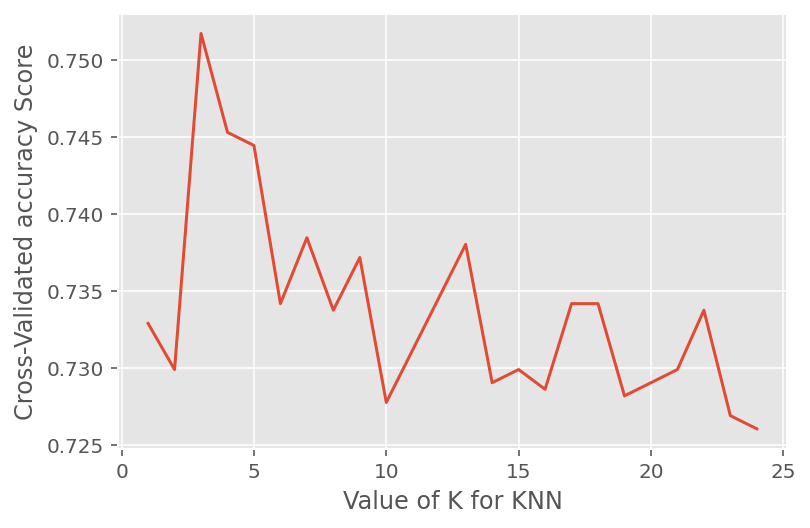

top performing n_neighbors value  {'n_neighbors': 4, 'p': 1}
top performing n_neighbors score  0.7547008547008547


In [45]:
#model 2 SMOTE and with EDA features
X = df2[predictors]
y = df2['deny']

#creating train and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_test2 = X_test.copy() # Copy for the final testing unit.
y_test2 = y_test.copy() # copy for final testing unit.

best_params = cross_validate_knn(X_train, y_train, 'accuracy')
best_k = best_params['n_neighbors']
best_distance = best_params['p']

# use the same model as before
knn_2 = KNeighborsClassifier(n_neighbors = 5, p = best_distance)
knn_2.fit(X_train,y_train)

accuracy = cross_val_score(knn_2, X_train, y_train, scoring = "accuracy", cv = 5)
recall = cross_val_score(knn_2, X_train, y_train, scoring = "recall", cv = 5)
auc = cross_val_score(knn_2, X_train, y_train, scoring = "roc_auc", cv = 5)
f1 = cross_val_score(knn_2, X_train, y_train, scoring = "f1", cv = 5)
precision = cross_val_score(knn_2, X_train, y_train, scoring = "precision", cv = 5)

accuracy_list.append(accuracy.mean())
recall_list.append(recall.mean())
auc_list.append(auc.mean())
f1_list.append(f1.mean())
precision_list.append(precision.mean())

The top performing number of neighbors (K) is 4, however for this second KNN we used the next highest performance k, which is 5 to use an odd number and break any possible tie.

### KNN - Model 3

As we mentioned previously, the data after applying SMOTE has a null error rate of 0.5, hence we can use 'accuracy' as an effective metric to evaluate this model.

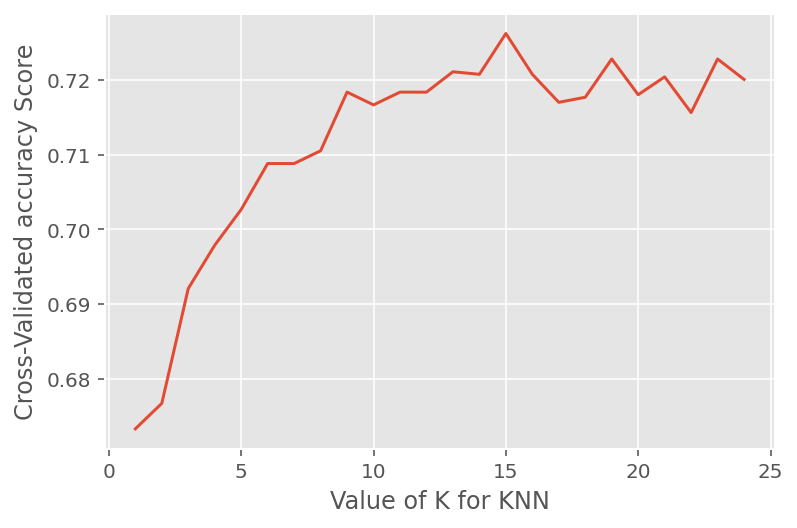

top performing n_neighbors value  {'n_neighbors': 15, 'p': 1}
top performing n_neighbors score  0.7262460254951723


In [46]:
#model 2 SMOTE and with EDA features
X = df2[predictors2]
y = df2['deny']

#creating train and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

best_params = cross_validate_knn(X, y, 'accuracy')
best_k = best_params['n_neighbors']
best_distance = best_params['p']

# use the same model as before
knn_3 = KNeighborsClassifier(n_neighbors = best_k, p = best_distance)
knn_3.fit(X_train,y_train)

accuracy = cross_val_score(knn_3, X_train, y_train, scoring = "accuracy", cv = 5)
recall = cross_val_score(knn_3, X_train, y_train, scoring = "recall", cv = 5)
auc = cross_val_score(knn_3, X_train, y_train, scoring = "roc_auc", cv = 5)
f1 = cross_val_score(knn_3, X_train, y_train, scoring = "f1", cv = 5)
precision = cross_val_score(knn_3, X_train, y_train, scoring = "precision", cv = 5)

accuracy_list.append(accuracy.mean())
recall_list.append(recall.mean())
auc_list.append(auc.mean())
f1_list.append(f1.mean())
precision_list.append(precision.mean())

The top performing number of neighbors (K) is 15 with Manhattan distance. Below we create a matrix to compare the three KNN performance metric.

In [47]:
print("\t \t The Model Metric Matrix")
# Cross validation.
metrics_summary = pd.DataFrame()
metrics_summary['Model #'] = ['KNN Model 1', 'KNN Model 2', 'KNN Model 3']
metrics_summary['Recall'] = recall_list
metrics_summary['Accuracy'] = accuracy_list
metrics_summary['Precision'] = precision_list
metrics_summary['AUC'] = auc_list
metrics_summary['F1_score'] = f1_list
metrics_summary

	 	 The Model Metric Matrix


,Model #,Recall,Accuracy,Precision,AUC,F1_score
0,KNN Model 1,0.270000,0.900209,0.681583,0.707334,0.384164
1,KNN Model 2,0.745992,0.747009,0.752475,0.817415,0.749189
2,KNN Model 3,0.694515,0.720513,0.738865,0.783131,0.715577


We can see the KNN model 2 has the highest accuracy compared to model 3. We do not consider model 1 as having very low recall. Below we take a look at the response variable with the 2 numeric to try to understand if it is linearly separable.

C:\Users\julir\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\julir\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\julir\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\julir\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


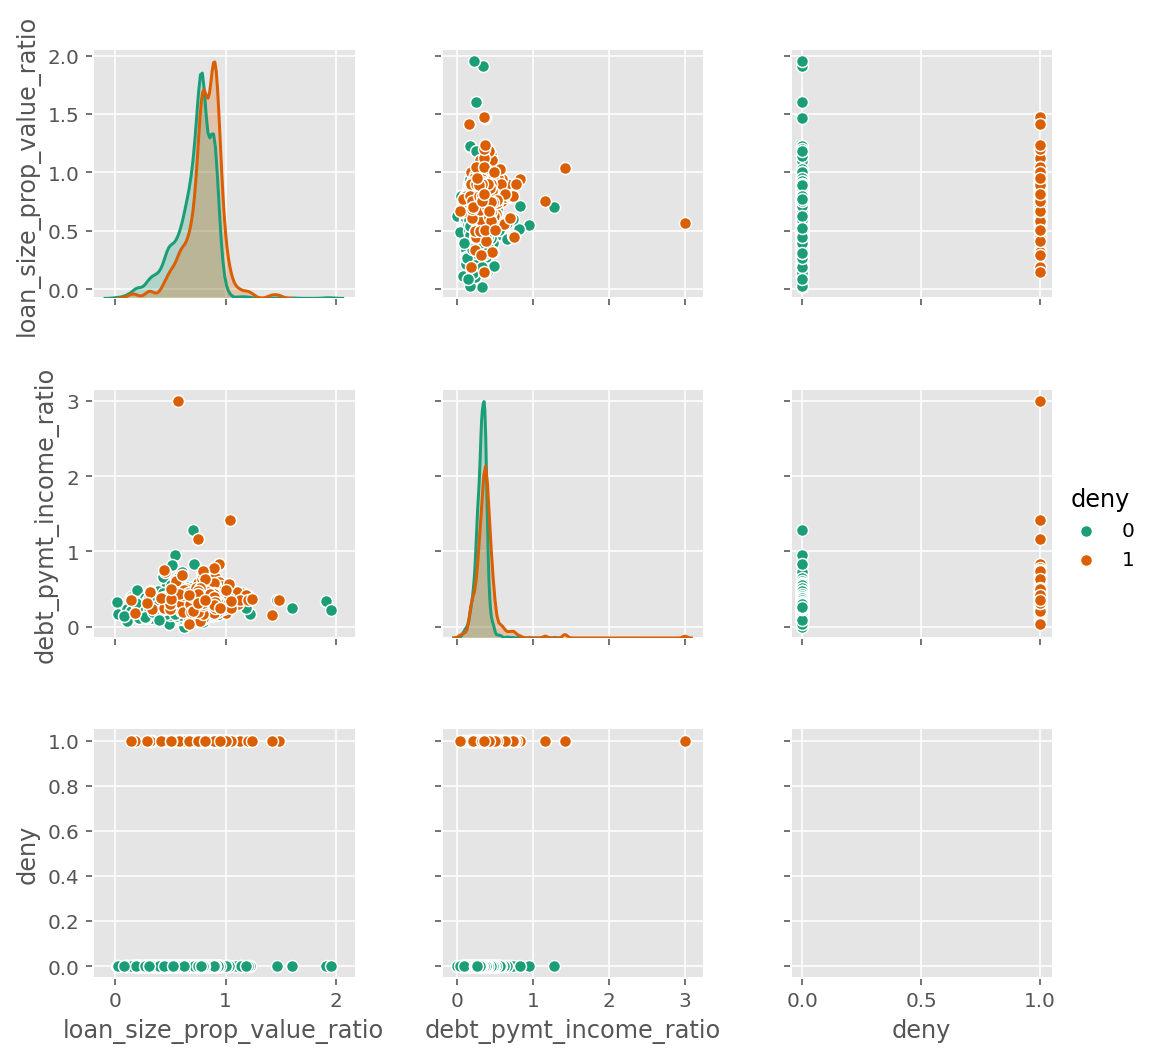

In [48]:
sns.pairplot(df[['loan_size_prop_value_ratio',
                 'debt_pymt_income_ratio',
                 'deny']],hue='deny',palette='Dark2');

Looking only at this 2 numeric variables we can see that the data is aparently not linearly separable. Next we will explore SVM and create 3 models.

## Approach for SVM Models
Since we are going to perform a classification task, we will use the support vector classifier class, which is written as __SVC__ in the Scikit-Learn's svm library starting with linear models and then applying kernels to transform the data to a higher dimension:
- __Standarization:__ as described in sklearn documentation this is a common requirement for many machine learning estimators, as they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance). For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.
- __kernel:__ Apply kernels to transform the data to a higher dimension.
- __degree:__ Degree is a parameter used when kernel is set to ‘poly’. It’s basically the degree of the polynomial used to find the hyperplane to split the data. In this case we will try 2 values: 2 and 3.

Regularization parameters:
- __C:__ regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. Large value of 'c' means you will get more intricate decision curves trying to fit in all the points. Figuring out how much you want to have a smooth decision boundary vs one that gets things correct is part of artistry of machine learning. So try different values of c for your dataset to get the perfectly balanced curve and avoid over fitting.  <br>
For our first parameter C: so we choose to values incrementally. First we start with one small and the other large to understand whether or not it works best with smaller values or larger values. When C=1: the SVM boundaries will be wider allowing a large amount of margin violations but will probably generalize better. Whereas, when C=10 the model results in a narrower boundary.

- __gamma:__  
“Increasing gamma makes the bell-shaped curve narrower. As a result, each instance’s range of influence is smaller: the decision boundary ends up being more irregular, wiggling around individual instances. Conversely, a small gamma value makes the
bell-shaped curve wider: instances have a larger range of influence, and the decision boundary ends up smoother.” That's why it is essential to choose the appropriate value for gamma. In this assignment we choose 2 values: 1 and 0.1 [5]


### SVM - Model 1

As a rule of thumb in the creation of support vector machines we first create an SVM model without the use of kernel tricks 
(a linear SVM), so in this section we are going to be experimenting with a linear SVM to later on construct a more sophisticated model which can predict the data better.

In [ ]:
#model 1 with EDA features
X = df[predictors] 
y = df['deny']

#creating train and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

linear_svm = make_pipeline(SVC(kernel='linear'))

linear_svm.fit(X_train, y_train)

cross_val_score(linear_svm, X_train, y_train, scoring = "f1", cv = 5).mean()

0.2505513824198994

F1 score is really low, we will try Polynomial features changing the value of the hyperparameter C to test the soft margin.

In [ ]:
#polynomial without kernel trick
polynomial_svm = make_pipeline(PolynomialFeatures(degree=3),
                               SVC(kernel = 'linear', C=10))
polynomial_svm.fit(X_train, y_train)
cross_val_score(polynomial_svm, X_train, y_train, scoring = "f1", cv = 5).mean()

0.4176546564974723

In [ ]:
#polynomial without kernel trick
polynomial_svm = make_pipeline(PolynomialFeatures(degree=3),
                               SVC(kernel = 'linear', C=1))
polynomial_svm.fit(X_train, y_train)
cross_val_score(polynomial_svm, X_train, y_train, scoring = "f1", cv = 5).mean()

0.413426999371788

We can see that the F1 score improved. We will explore kernel tricks using gridsearch to try different combinations.

#### Using GridSearch for Kernels and Regularization Parameters
#### Linear + Non-linear (grid search)
Since there are a great deal of parameters involved in the creation of a support vector machine, we are going to be using grid search to look for the best possible combination of parameters from the parameter pool that we suspect to have a positive effect on our SVM model.[1]

In [ ]:
#perform gridsearch to get highest score
param_grid = {'C': [1, 10], 'degree':[2,3], 'gamma': [1,0.1], 'kernel': ['rbf', 'poly', 'sigmoid']} #use gridsearch to test all values for n_neighbors
svc_grid_1 = GridSearchCV(SVC(), param_grid, scoring = 'f1') # Fit model to data

In [ ]:
svc_grid_1.fit(X_train,y_train)

In [ ]:
print(svc_grid_1.best_params_)

In [102]:
print(svc_grid_1.best_score_)

0.7358732470297914


Gridsearch provided the best parameters for our KNN model, and we can see that any kernel was included so we will keep the f1 provided by the polynomial with C=10 and degree=3

In [98]:
#polynomial without kernel trick
kernel_svm_1 = make_pipeline(PolynomialFeatures(degree=2),
                               SVC(kernel = 'rbf', C=10, gamma=1))
kernel_svm_1.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('svc', SVC(C=10, gamma=1))])

In [123]:
accuracy = cross_val_score(kernel_svm_1, X_train, y_train, scoring = "accuracy", cv = 5)
recall = cross_val_score(kernel_svm_1, X_train, y_train, scoring = "recall", cv = 5)
auc = cross_val_score(kernel_svm_1, X_train, y_train, scoring = "roc_auc", cv = 5)
f1 = cross_val_score(kernel_svm_1, X_train, y_train, scoring = "f1", cv = 5)
precision = cross_val_score(kernel_svm_1, X_train, y_train, scoring = "precision", cv = 5)

accuracy_list.append(accuracy.mean())
recall_list.append(recall.mean())
auc_list.append(auc.mean())
f1_list.append(f1.mean())
precision_list.append(precision.mean())

### SVM - Model 2
#### Linear + Non-linear (gridsearch)

Model 2 and model 3, we will work on the dataset that was oversampled using SMOTE, so we will use accuracy as our metric to pick the best model.

In [66]:
#model 1 with EDA features
X = df2[predictors] 
y = df2['deny']

#creating train and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

linear_svm = make_pipeline(StandardScaler(),
                           SVC(kernel='linear'))
linear_svm.fit(X_train, y_train)
cross_val_score(linear_svm, X_train, y_train, scoring = "accuracy", cv = 5).mean()

0.7145299145299144

In [67]:
#polynomial without kernel trick
polynomial_svm = make_pipeline(PolynomialFeatures(degree=3),
                               StandardScaler(), 
                               SVC(kernel = 'linear', C=10))
polynomial_svm.fit(X_train, y_train)
cross_val_score(polynomial_svm, X_train, y_train, scoring = "accuracy", cv = 5).mean()

0.7277777777777779

In [68]:
#polynomial without kernel trick
polynomial_svm = make_pipeline(PolynomialFeatures(degree=3),
                               StandardScaler(), 
                               SVC(kernel = 'linear', C=1))
polynomial_svm.fit(X_train, y_train)
cross_val_score(polynomial_svm, X_train, y_train, scoring = "accuracy", cv = 5).mean()

0.7247863247863248

#### Using GridSearch for Kernels and Regularization Parameters
Since there are a great deal of parameters involved in the creation of a support vector machine, we are going to be using grid search to look for the best possible combination of parameters from the parameter pool that we suspect to have a positive effect on our SVM model.[1]

In [87]:
#perform gridsearch to get highest score
param_grid = {'C': [1, 10], 'degree':[2,3], 'gamma': [1,0.1], 'kernel': ['rbf', 'poly', 'sigmoid']}#use gridsearch to test all values for n_neighbors
svc_grid_2 = GridSearchCV(SVC(), param_grid, cv=5, scoring = 'accuracy')#fit model to data
svc_grid_2.fit(X_train,y_train)
#print(svc_grid.best_estimator_)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10], 'degree': [2, 3], 'gamma': [1, 0.1],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

In [108]:
svc_grid_2.best_score_

0.7461538461538462

In [109]:
svc_grid_2.best_index_

12

In [110]:
svc_grid_2.best_params_

{'C': 10, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}

In [111]:
#polynomial without kernel trick
kernel_svm_2 = make_pipeline(SVC(kernel = 'rbf', C=10, gamma=1))
kernel_svm_2.fit(X_train, y_train)

Pipeline(steps=[('svc', SVC(C=10, gamma=1))])

In [124]:
accuracy = cross_val_score(kernel_svm_2, X_train, y_train, scoring = "accuracy", cv = 5)
recall = cross_val_score(kernel_svm_2, X_train, y_train, scoring = "recall", cv = 5)
auc = cross_val_score(kernel_svm_2, X_train, y_train, scoring = "roc_auc", cv = 5)
f1 = cross_val_score(kernel_svm_2, X_train, y_train, scoring = "f1", cv = 5)
precision = cross_val_score(kernel_svm_2, X_train, y_train, scoring = "precision", cv = 5)

accuracy_list.append(accuracy.mean())
recall_list.append(recall.mean())
auc_list.append(auc.mean())
f1_list.append(f1.mean())
precision_list.append(precision.mean())

### SVM - Model 3
#### Linear + Non-linear (gridsearch)


In [103]:
#model 1 with EDA features
X = df2[predictors2] 
y = df2['deny']

#creating train and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

linear_svm = make_pipeline(StandardScaler(),
                           SVC(kernel='linear'))
linear_svm.fit(X_train, y_train)
cross_val_score(linear_svm, X_train, y_train, scoring = "accuracy", cv = 5).mean()

0.6854700854700855

In [104]:
#polynomial without kernel trick
polynomial_svm = make_pipeline(PolynomialFeatures(degree=3),
                               StandardScaler(), 
                               SVC(kernel = 'linear', C=10))
polynomial_svm.fit(X_train, y_train)
cross_val_score(polynomial_svm, X_train, y_train, scoring = "accuracy", cv = 5).mean()

0.708119658119658

In [105]:
#polynomial without kernel trick
polynomial_svm = make_pipeline(PolynomialFeatures(degree=3),
                               StandardScaler(), 
                               SVC(kernel = 'linear', C=1))
polynomial_svm.fit(X_train, y_train)
cross_val_score(polynomial_svm, X_train, y_train, scoring = "accuracy", cv = 5).mean()

0.7004273504273504

#### Using GridSearch for Kernels and Regularization Parameters

Since there are a great deal of parameters involved in the creation of a support vector machine, we are going to be using grid search to look for the best possible combination of parameters from the parameter pool that we suspect to have a positive effect on our SVM model.[1]

In [106]:
#perform gridsearch to get highest score
param_grid = {'C': [1, 10], 'degree':[2,3], 'gamma': [1,0.1], 'kernel': ['rbf', 'poly', 'sigmoid']}#use gridsearch to test all values for n_neighbors
svc_grid = GridSearchCV(SVC(), param_grid, cv=5, scoring = 'accuracy')#fit model to data

#print(svc_grid.best_params_)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10], 'degree': [2, 3], 'gamma': [1, 0.1],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='accuracy')

In [ ]:
svc_grid.fit(X_train,y_train)

In [107]:
print(svc_grid.best_params_)
print(svc_grid.best_score_)

{'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
0.7226495726495726


In [114]:
#polynomial without kernel trick
kernel_svm_3 = make_pipeline(SVC(kernel = 'rbf', C=1, gamma=1))
kernel_svm_3.fit(X_train, y_train)

Pipeline(steps=[('svc', SVC(C=1, gamma=1))])

In [125]:
accuracy = cross_val_score(kernel_svm_3, X_train, y_train, scoring = "accuracy", cv = 5)
recall = cross_val_score(kernel_svm_3, X_train, y_train, scoring = "recall", cv = 5)
auc = cross_val_score(kernel_svm_3, X_train, y_train, scoring = "roc_auc", cv = 5)
f1 = cross_val_score(kernel_svm_3, X_train, y_train, scoring = "f1", cv = 5)
precision = cross_val_score(kernel_svm_3, X_train, y_train, scoring = "precision", cv = 5)

accuracy_list.append(accuracy.mean())
recall_list.append(recall.mean())
auc_list.append(auc.mean())
f1_list.append(f1.mean())
precision_list.append(precision.mean())

In [127]:

# Cross validation.
metrics_summary = pd.DataFrame()
metrics_summary['Model #'] = ['KNN Model 1', 'KNN Model 2', 'KNN Model 3', 'SVM Model 1', 'SVM Model 2', 'SVM Model 3']
metrics_summary['Recall'] = recall_list
metrics_summary['Accuracy'] = accuracy_list
metrics_summary['Precision'] = precision_list
metrics_summary['AUC'] = auc_list
metrics_summary['F1_score'] = f1_list

	 	 The Model Metric Matrix


# Model Selection

To make a selection of the most predictive model, we collected through cross-validation different performance metrics and we will show them together in a dataframe for better understanding and to compare them easily to pick the best model. In the following section we will explain it from a metrics perspective and we will also review the class imbalance problem.


In [128]:
print("\t \t The Model Metric Matrix")
metrics_summary

	 	 The Model Metric Matrix


,Model #,Recall,Accuracy,Precision,AUC,F1_score
0,KNN Model 1,0.296667,0.884976,0.508899,0.690835,0.372656
1,KNN Model 2,0.761181,0.750855,0.750883,0.822374,0.755784
2,KNN Model 3,0.679325,0.715385,0.738756,0.780689,0.707480
3,SVM Model 1,0.646414,0.710684,0.748193,0.744017,0.693499
4,SVM Model 2,0.671730,0.717521,0.745312,0.756887,0.706491
5,SVM Model 3,0.676793,0.722650,0.750891,0.749153,0.711697


- KNN Model 1 & SVM Model 1
  These two models use the original dataset. This dataset is significantly imbalanced in terms of the response variable. In the response variable the amount applicants who were not denied were a great deal more than those who were denied. While KNN model 1 provides a high accuracy score of ~90%, we hesitate to choose it because of how unbalanced the data is. The effect of this imbalance was clearly visible when we look at the recall score pertaining to KNN model 1 which stands at ~25% which is very low and not be suitable for use. Conversely, SVM model 1 has a higher recall, but underperforms in the other metrics. Because of this we decided that it is best to disqualify these models.

- KNN Model 2 & 3
  Choosing between these two models was not a difficult choice as model 2 and model 3 (KNNs) were under the same condition (oversampling using SMOTE) and yet `KNN` model 2 outperformed model 3 in every single metric measured in this study. Consequently, we prefer model 2 `KNN` and disqualify model 3 `KNN`.

- SVM Model 2 & 3
  Model 2 `SVM` and Model 3 `SVM` have close scores in the evaluation metrics but did not perform as well as `KNN` model 2.

In sum, the best model here is the second KNN model. It outperforms every other model in every metric we measured in this study. 
Below we will compare the performance of this KNN model with the performance of the logistic regression from the previous assignment.

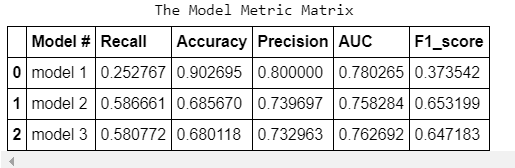

The figure above was from our previous assignment were we constructed 3 logistic regression models and provided their evaluation metrics scores.

As we can see in the metrics above from our previous assignment, the best logistic model here was model 2, and if we compare the 
our newly constructed KNN model 2 metrics it outperforms the logistic regression one in recall, accuracy, precision, AUC and F1 score. <br>
Now we will apply the selected KNN model 2 to the testing data.

In [136]:
print("Our final model:")
y_pred = knn_2.predict(X_test2[predictors])
print('Accuracy of K nearest neighbours classifier on test set: {:.2f}'.format(knn_2.score(X_test2[predictors], y_test2)))

Our final model
Accuracy of K nearest neighbours classifier on test set: 0.74


In [132]:
y_pred = pd.DataFrame(y_pred, columns = ['deny'])
y_test = pd.DataFrame(y_test2, columns = ['deny'])

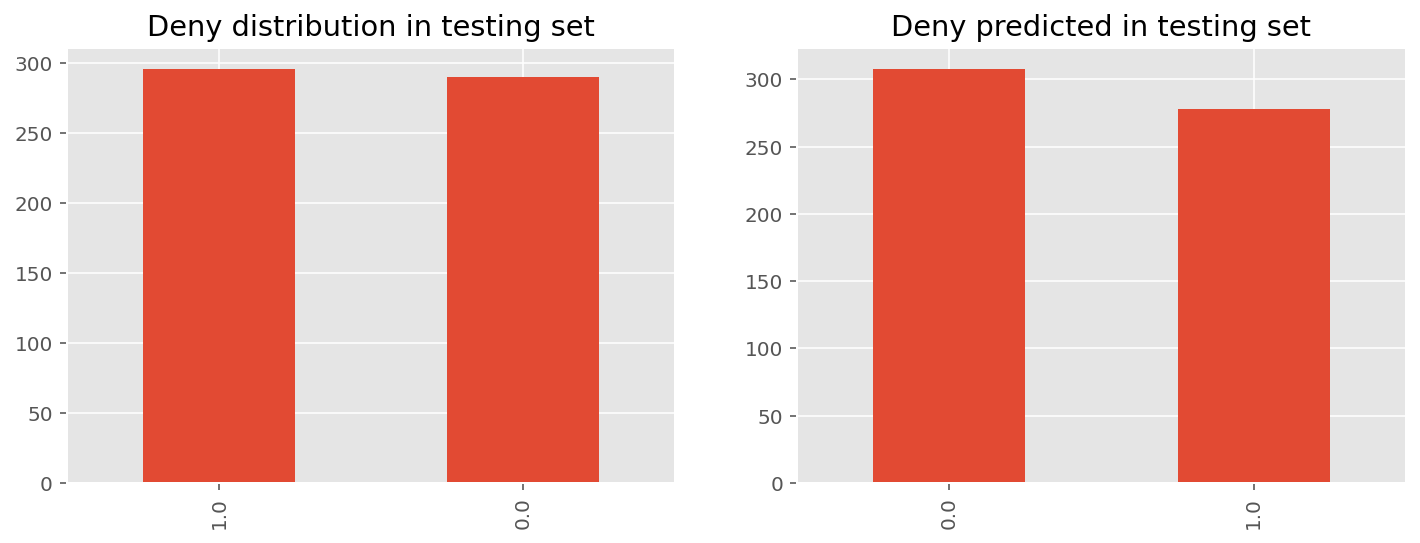

In [135]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
y_pred['deny'].value_counts().plot(kind='bar');
plt.title('Deny distribution in testing set')
plt.subplot(1,2,2)
y_test['deny'].value_counts().plot(kind='bar');
plt.title('Deny predicted in testing set')
plt.show();

We see that the selected model is getting values that are distributed similarly, however the model seems to have a bit more applications that got denied over those that are not denied than before.

# Conclusions
- From our EDA we extracted several features that had a relationship with the response variable and we also noticed that working with imbalance data would hinder model performance. To mitigate this, we trained appropriate models and tested their performance and selected the highest preforming combination which was our KNN model 2.
- when using an SVM Model the data does not seem to be linearly separable. To solve this, we had to apply a kernel trick in order to project the data values into a higher dimensionality so that we could separate the data classes using a hyperplane.
- The best performing number for K in our KNN model on this dataset here was 4. However, using an even number in this instance could have caused issues as there is an even number of classes and KNN classifies according to the highest vote. Because of this we are running the risk of having a tie. In order to avoid this, we opted for the closest value to 4 with optimal performance which was the number 5. This allowed us to have an odd number which would help us circumvent this problem while maintaining a high-level of performance.
- This model is the best model we have so far, however in order for an SVM to perform better it requires a lot more data.

# Refrences
[1] https://towardsdatascience.com/svm-hyper-parameter-tuning-using-gridsearchcv-49c0bc55ce29

[2] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

[3] https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-106

[4] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

[5] Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, Chapter 5. Support Vector Machines